## IBM Quantum Authentication Successful

## Backend Selected: ibm_brisbane

* Status: Operational

* Qubit Count: 127

* Pending Jobs: 2

---
### Circuit for |000⟩

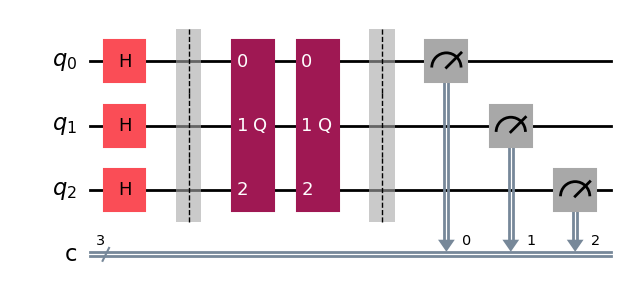

#### Decomposed circuit for |000⟩

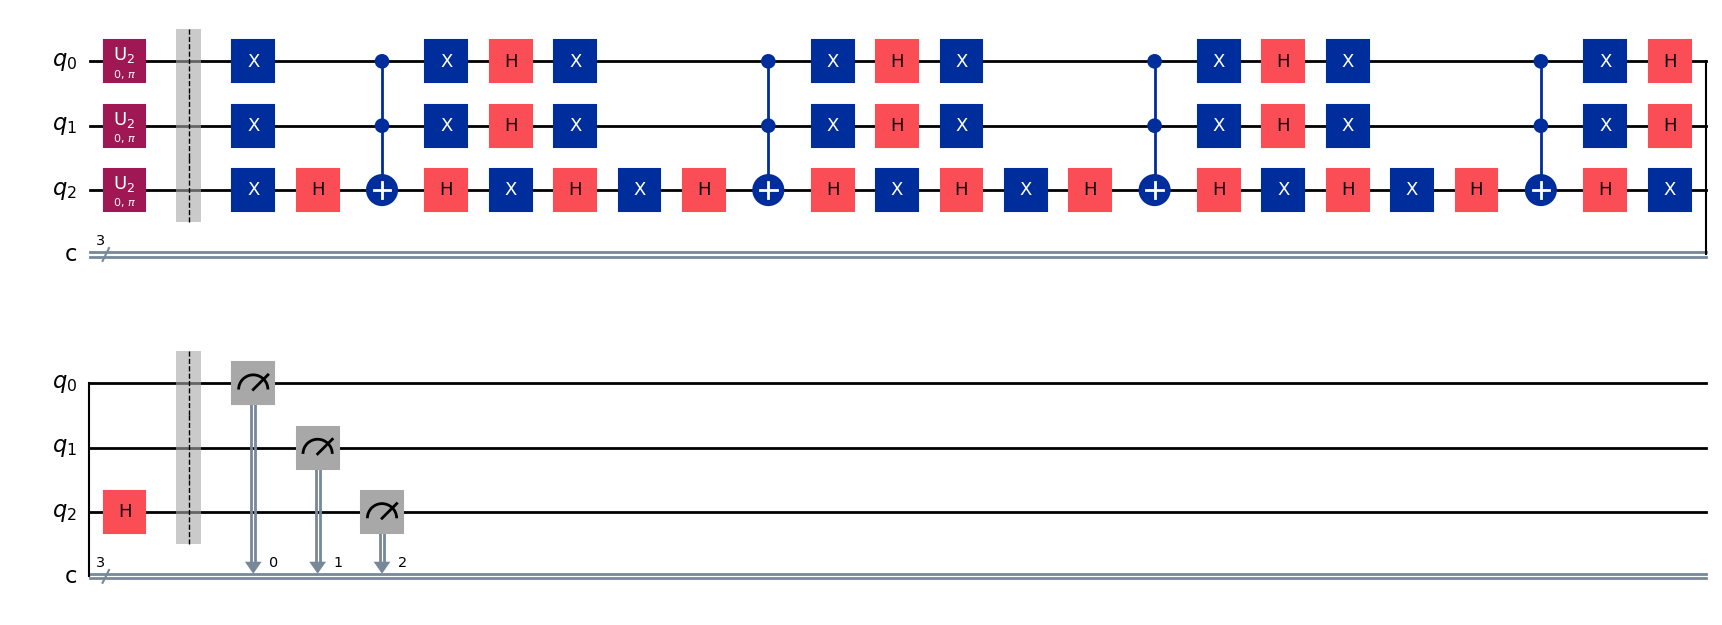

**Simulator results for |000⟩:** `{'101': 8, '100': 8, '110': 9, '001': 4, '000': 974, '010': 5, '111': 8, '011': 8}`

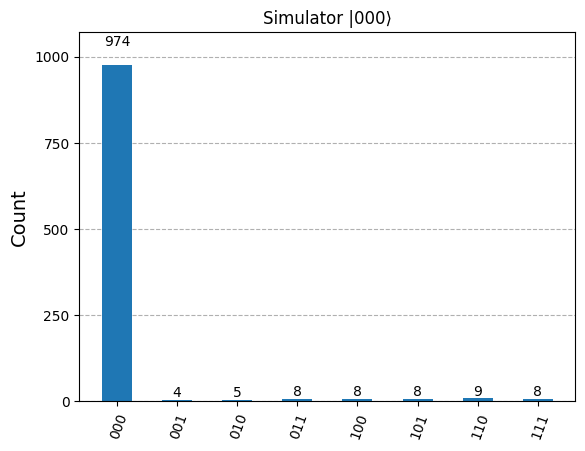

---
### Circuit for |001⟩

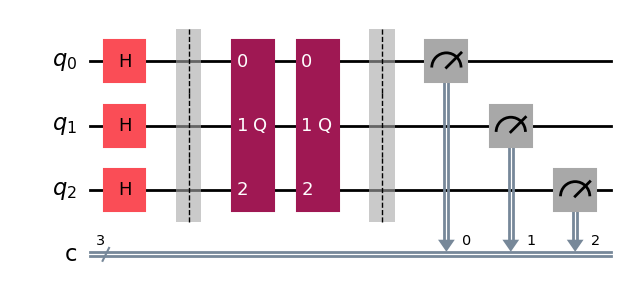

#### Decomposed circuit for |001⟩

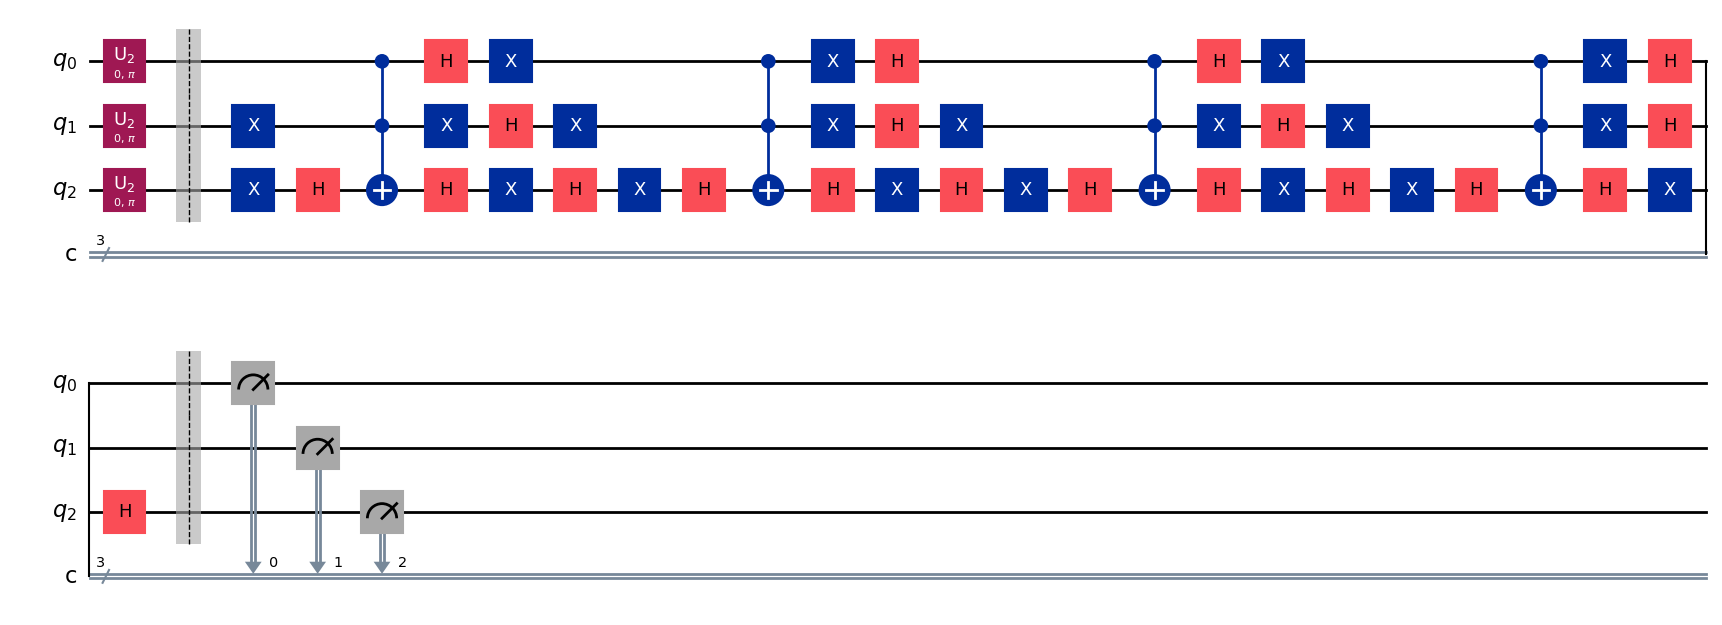

**Simulator results for |001⟩:** `{'000': 10, '010': 6, '001': 972, '110': 8, '100': 9, '111': 7, '011': 7, '101': 5}`

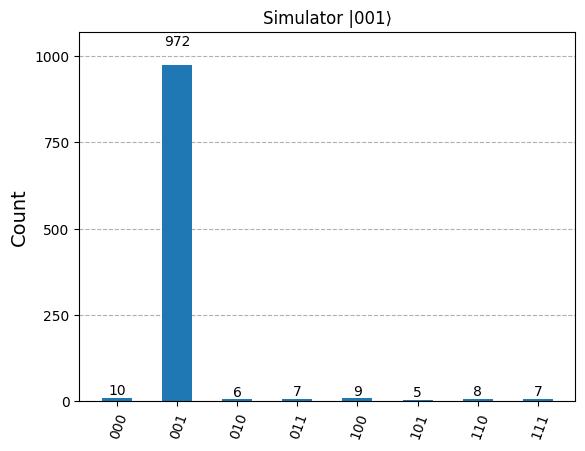

---
### Circuit for |010⟩

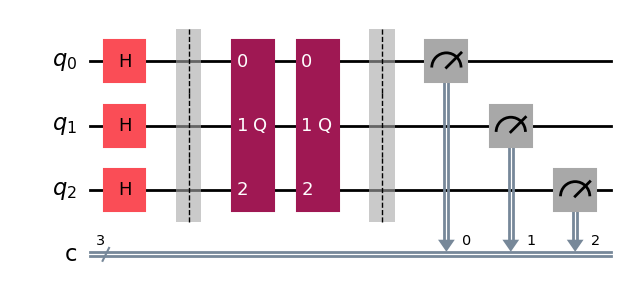

#### Decomposed circuit for |010⟩

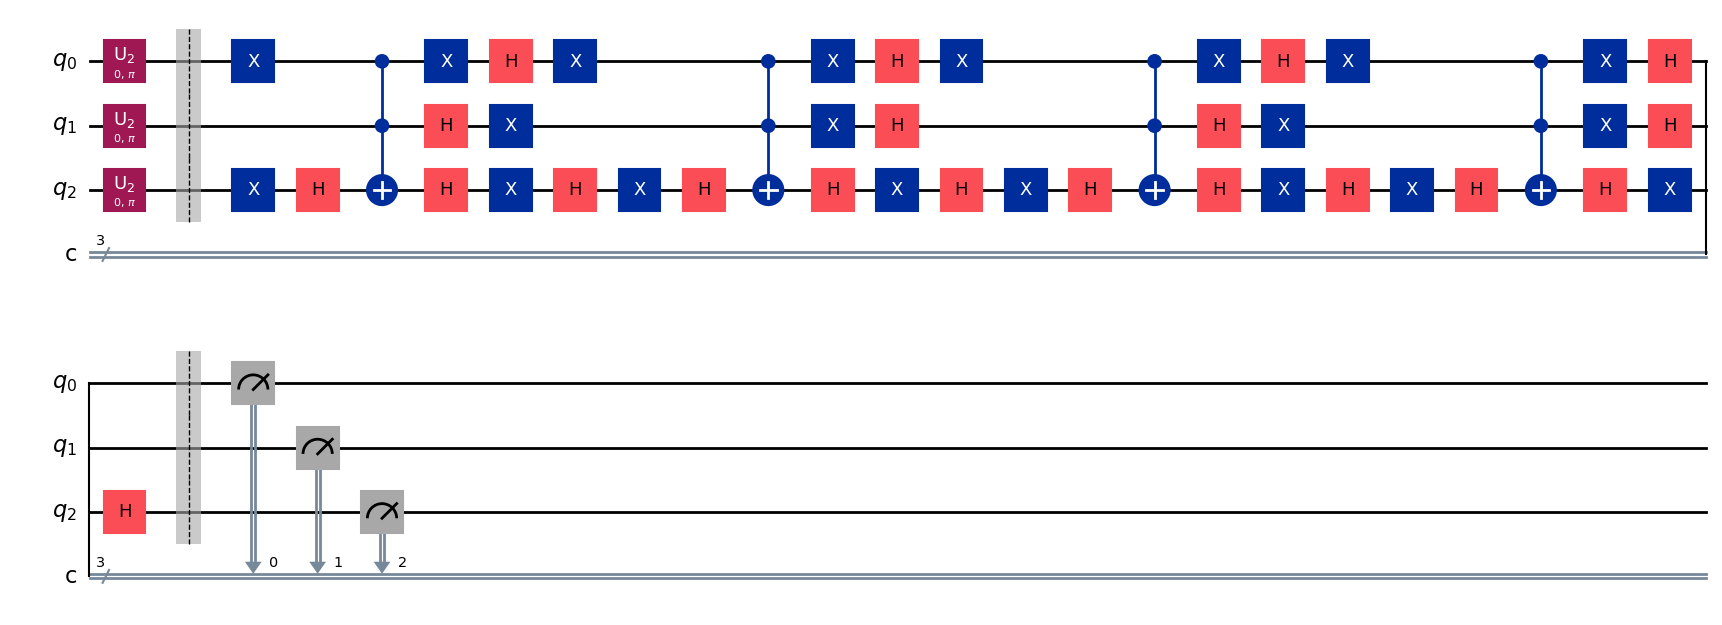

**Simulator results for |010⟩:** `{'011': 5, '111': 12, '110': 8, '001': 8, '100': 7, '010': 966, '000': 11, '101': 7}`

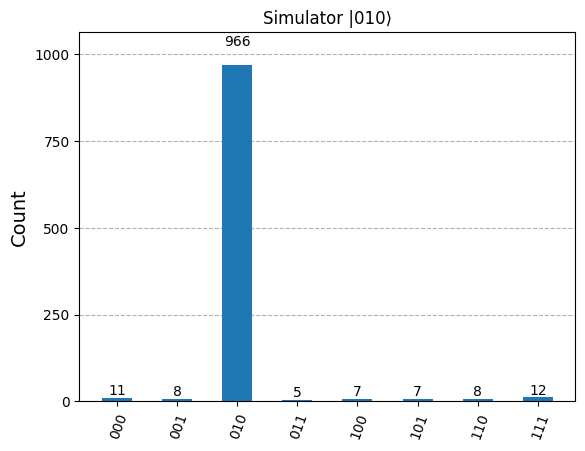

---
### Circuit for |011⟩

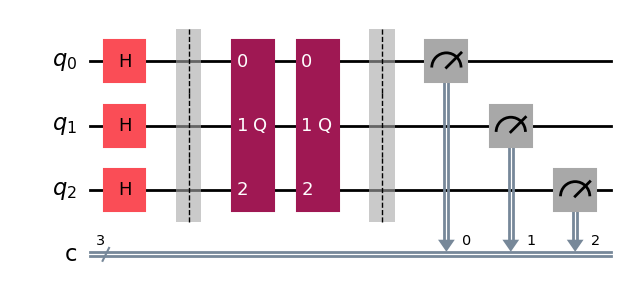

#### Decomposed circuit for |011⟩

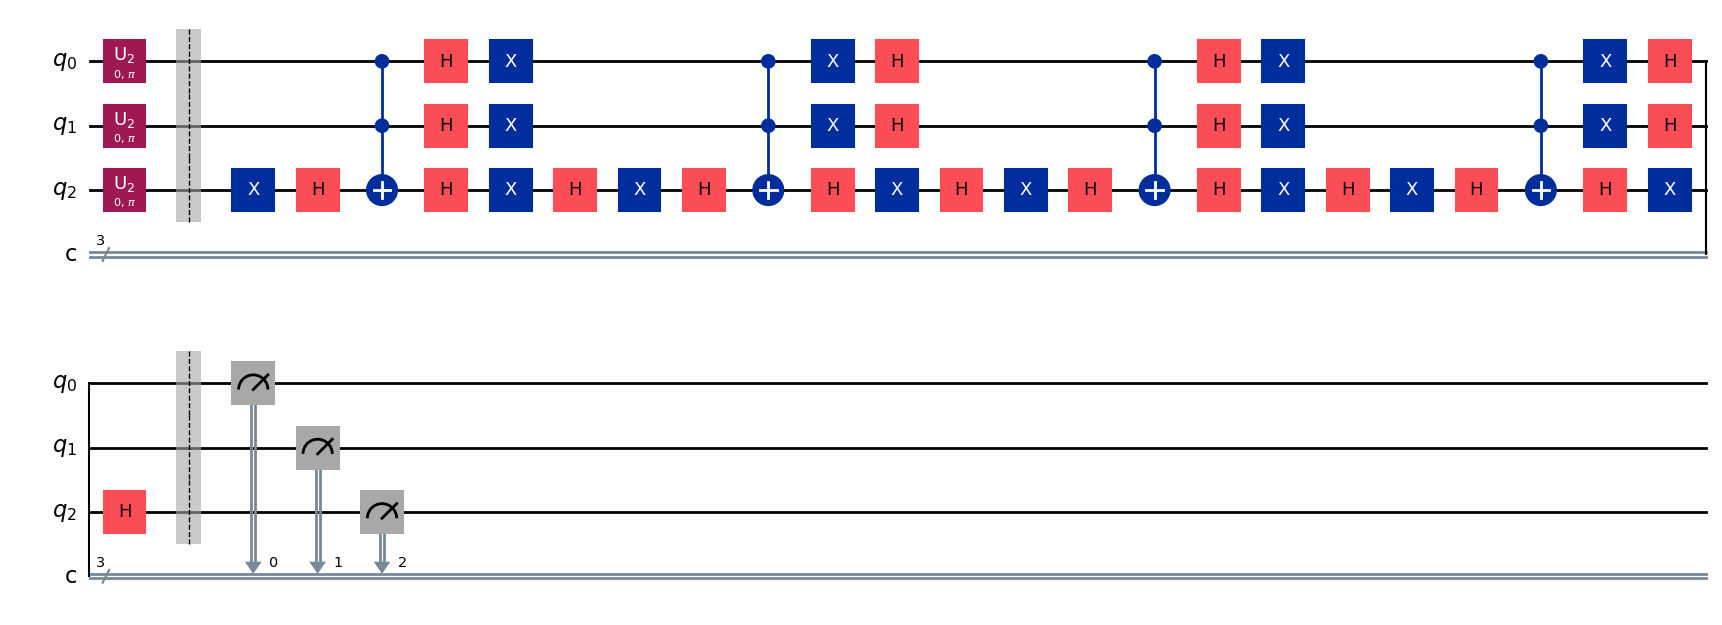

**Simulator results for |011⟩:** `{'100': 7, '001': 5, '110': 10, '101': 7, '000': 7, '010': 6, '111': 4, '011': 978}`

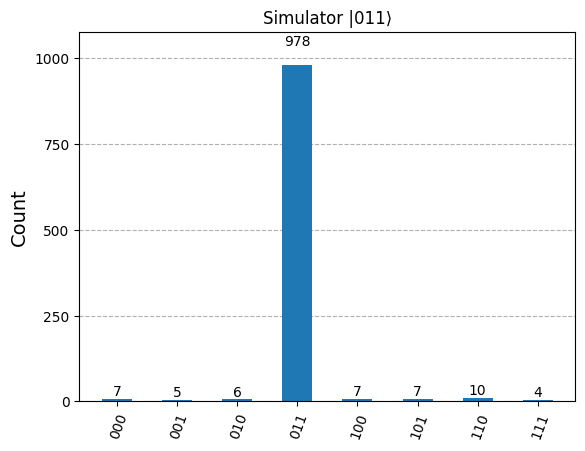

---
### Circuit for |100⟩

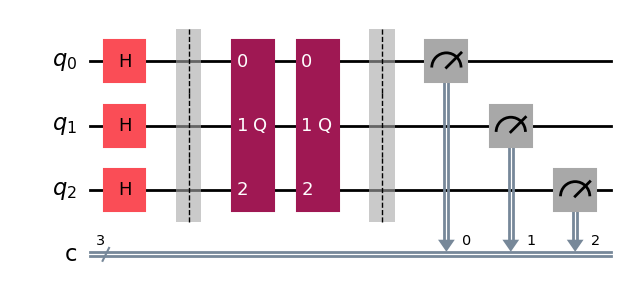

#### Decomposed circuit for |100⟩

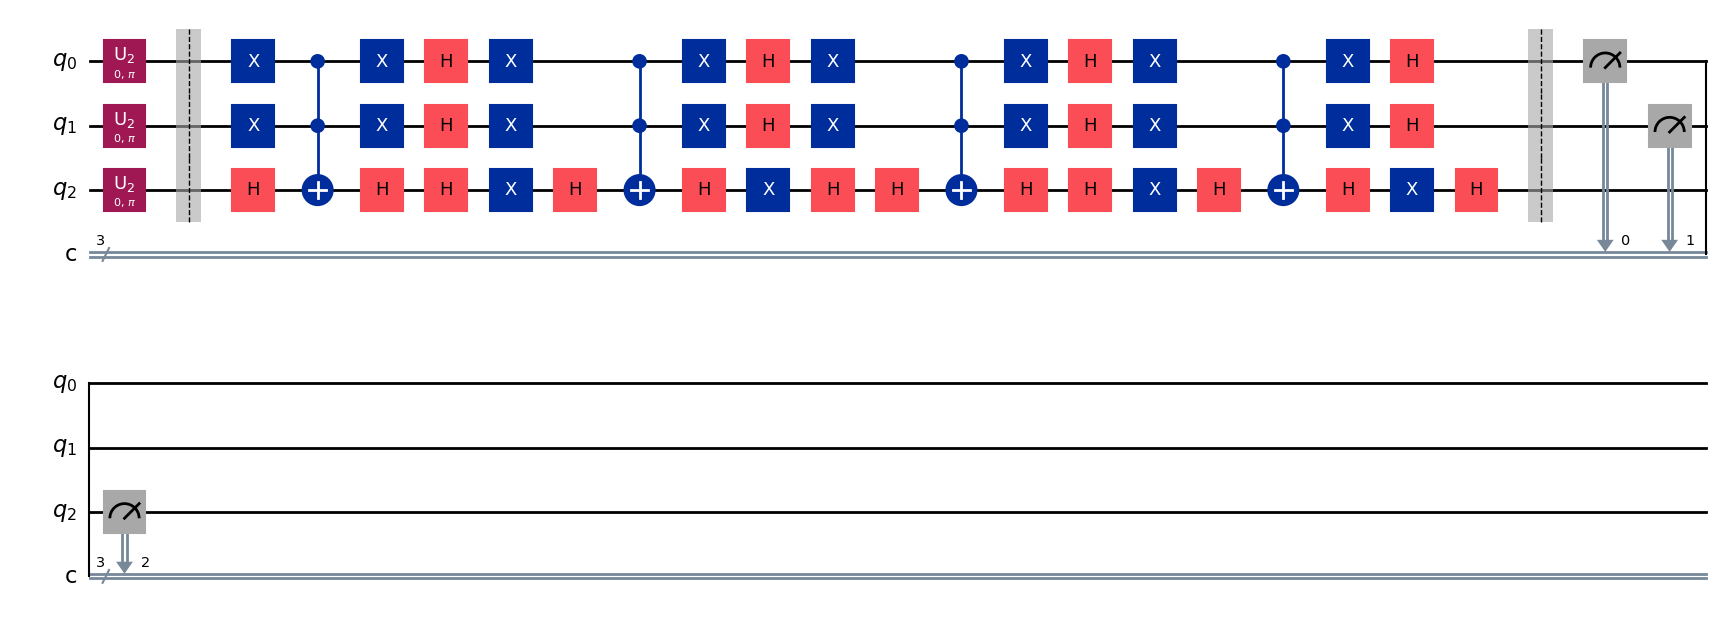

**Simulator results for |100⟩:** `{'101': 11, '000': 6, '010': 10, '100': 967, '001': 8, '110': 8, '111': 7, '011': 7}`

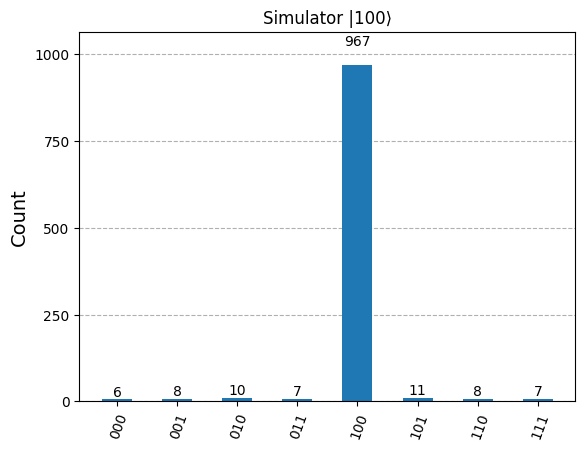

---
### Circuit for |101⟩

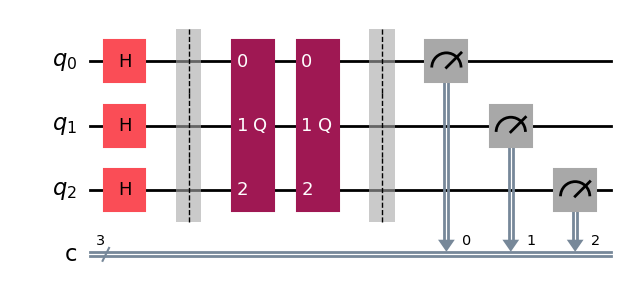

#### Decomposed circuit for |101⟩

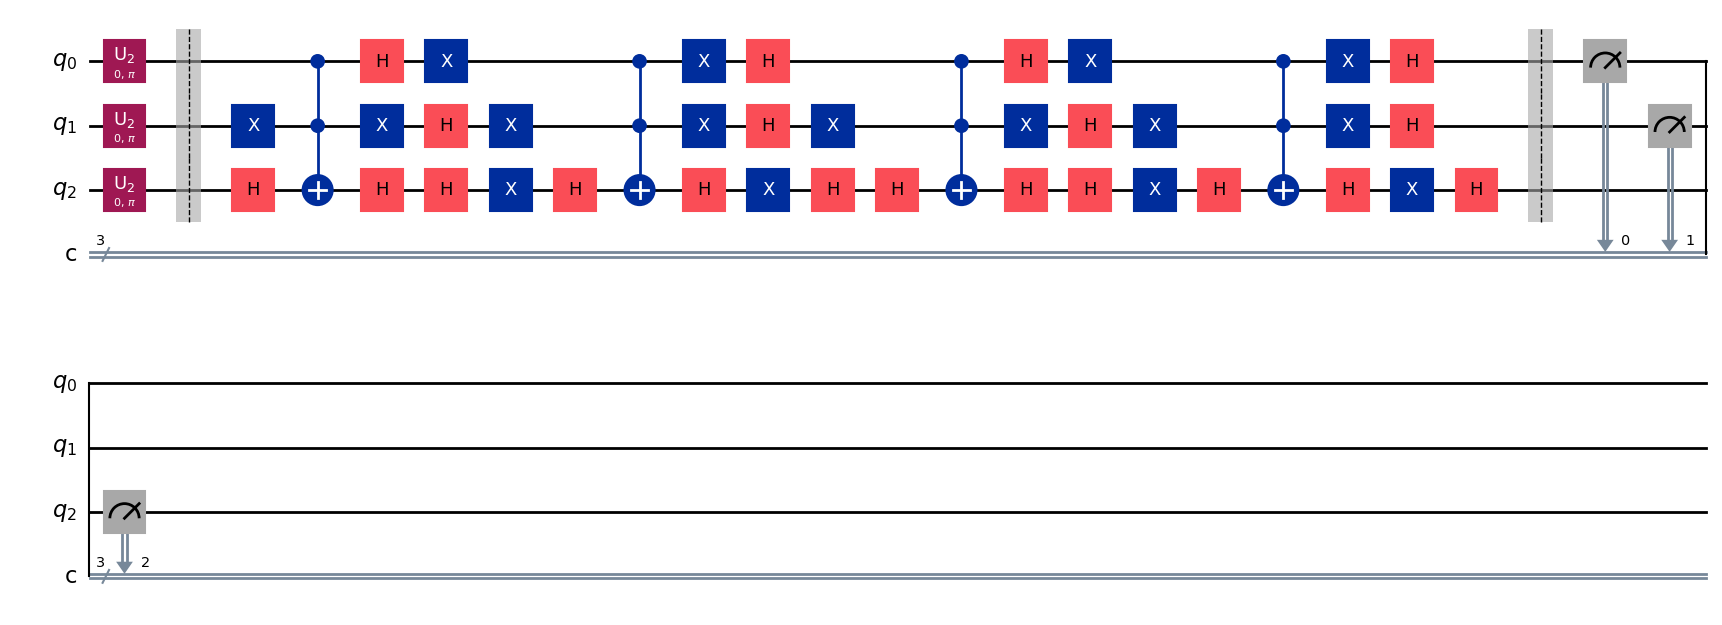

**Simulator results for |101⟩:** `{'010': 6, '000': 7, '110': 8, '001': 7, '100': 7, '111': 7, '011': 4, '101': 978}`

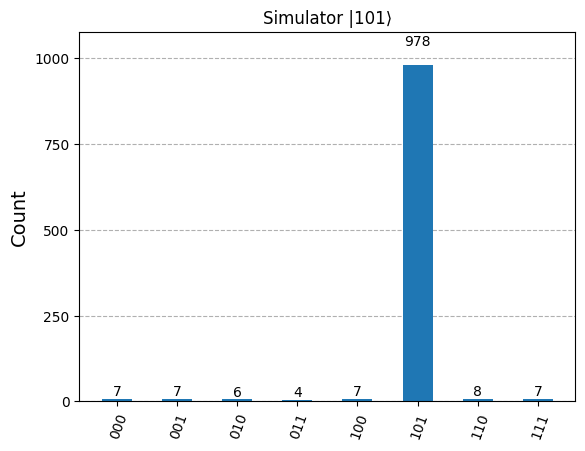

---
### Circuit for |110⟩

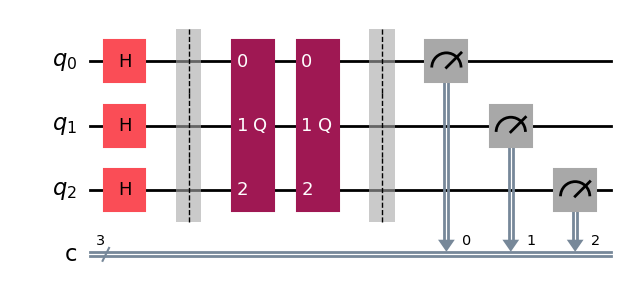

#### Decomposed circuit for |110⟩

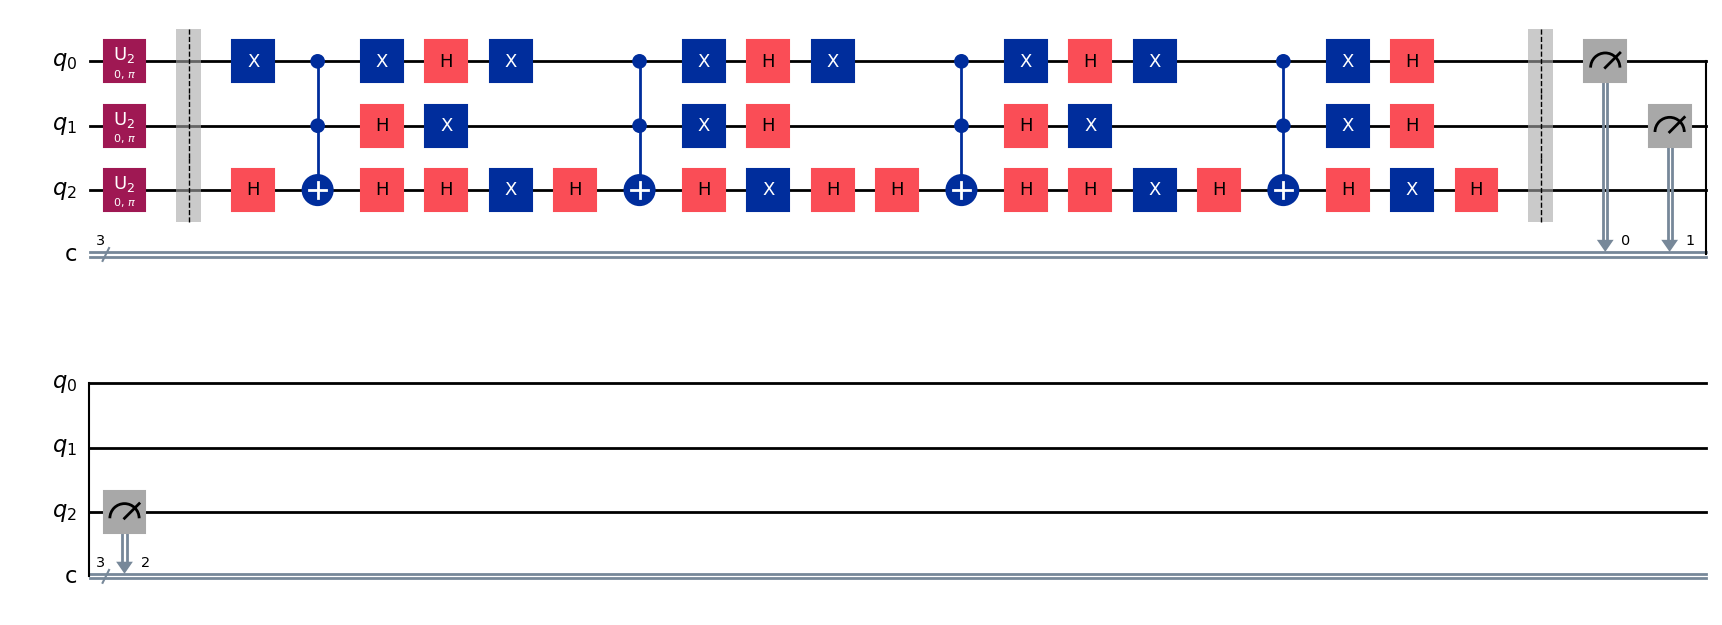

**Simulator results for |110⟩:** `{'000': 13, '010': 8, '101': 10, '011': 13, '111': 10, '001': 7, '110': 949, '100': 14}`

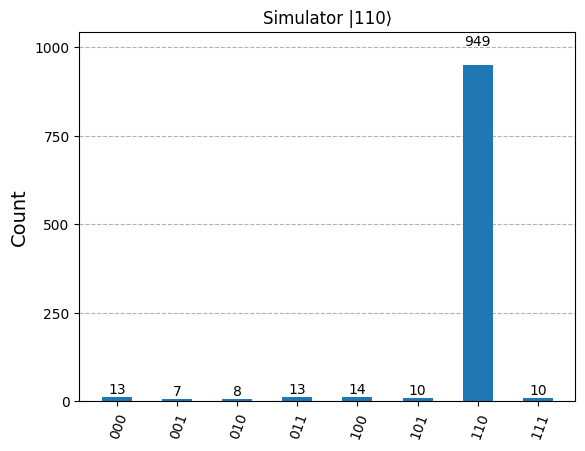

---
### Circuit for |111⟩

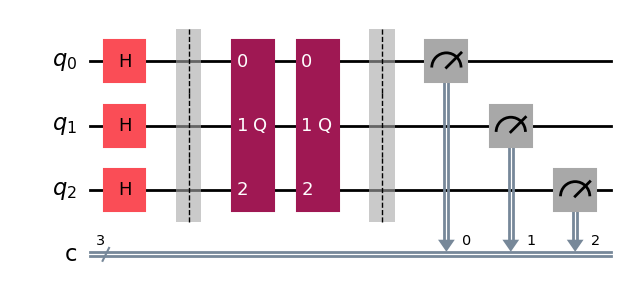

#### Decomposed circuit for |111⟩

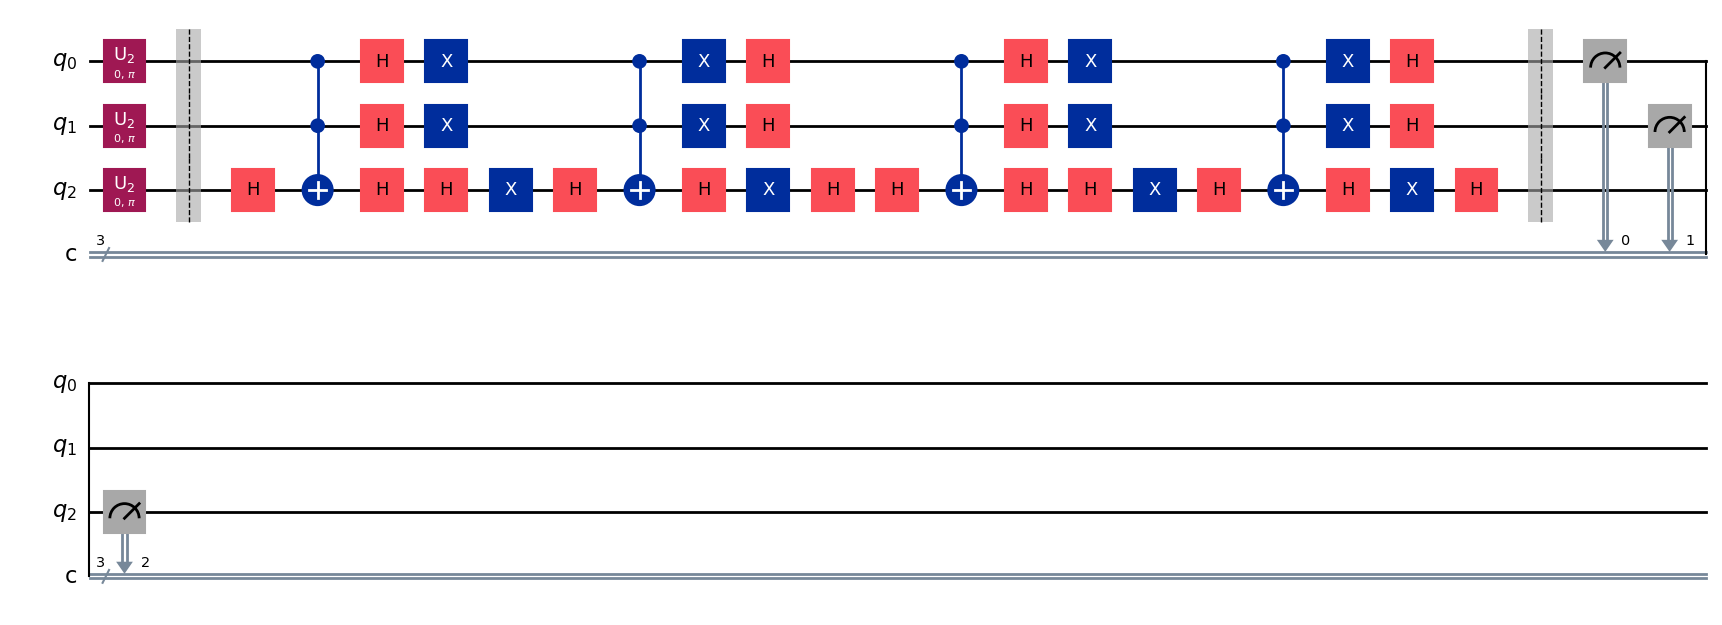

**Simulator results for |111⟩:** `{'100': 6, '110': 7, '001': 9, '111': 969, '011': 6, '010': 6, '000': 10, '101': 11}`

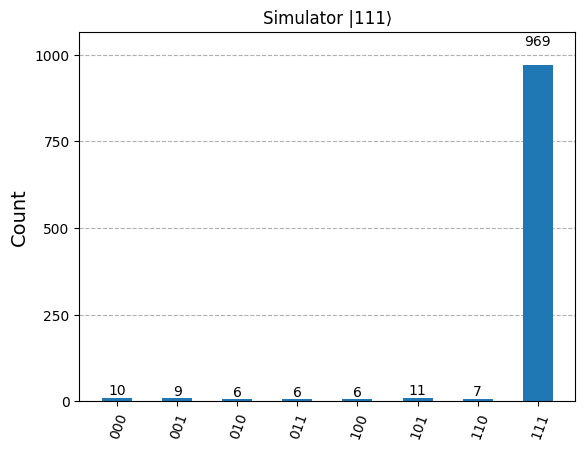

**Transpiled circuit |000⟩ on ibm_brisbane:**

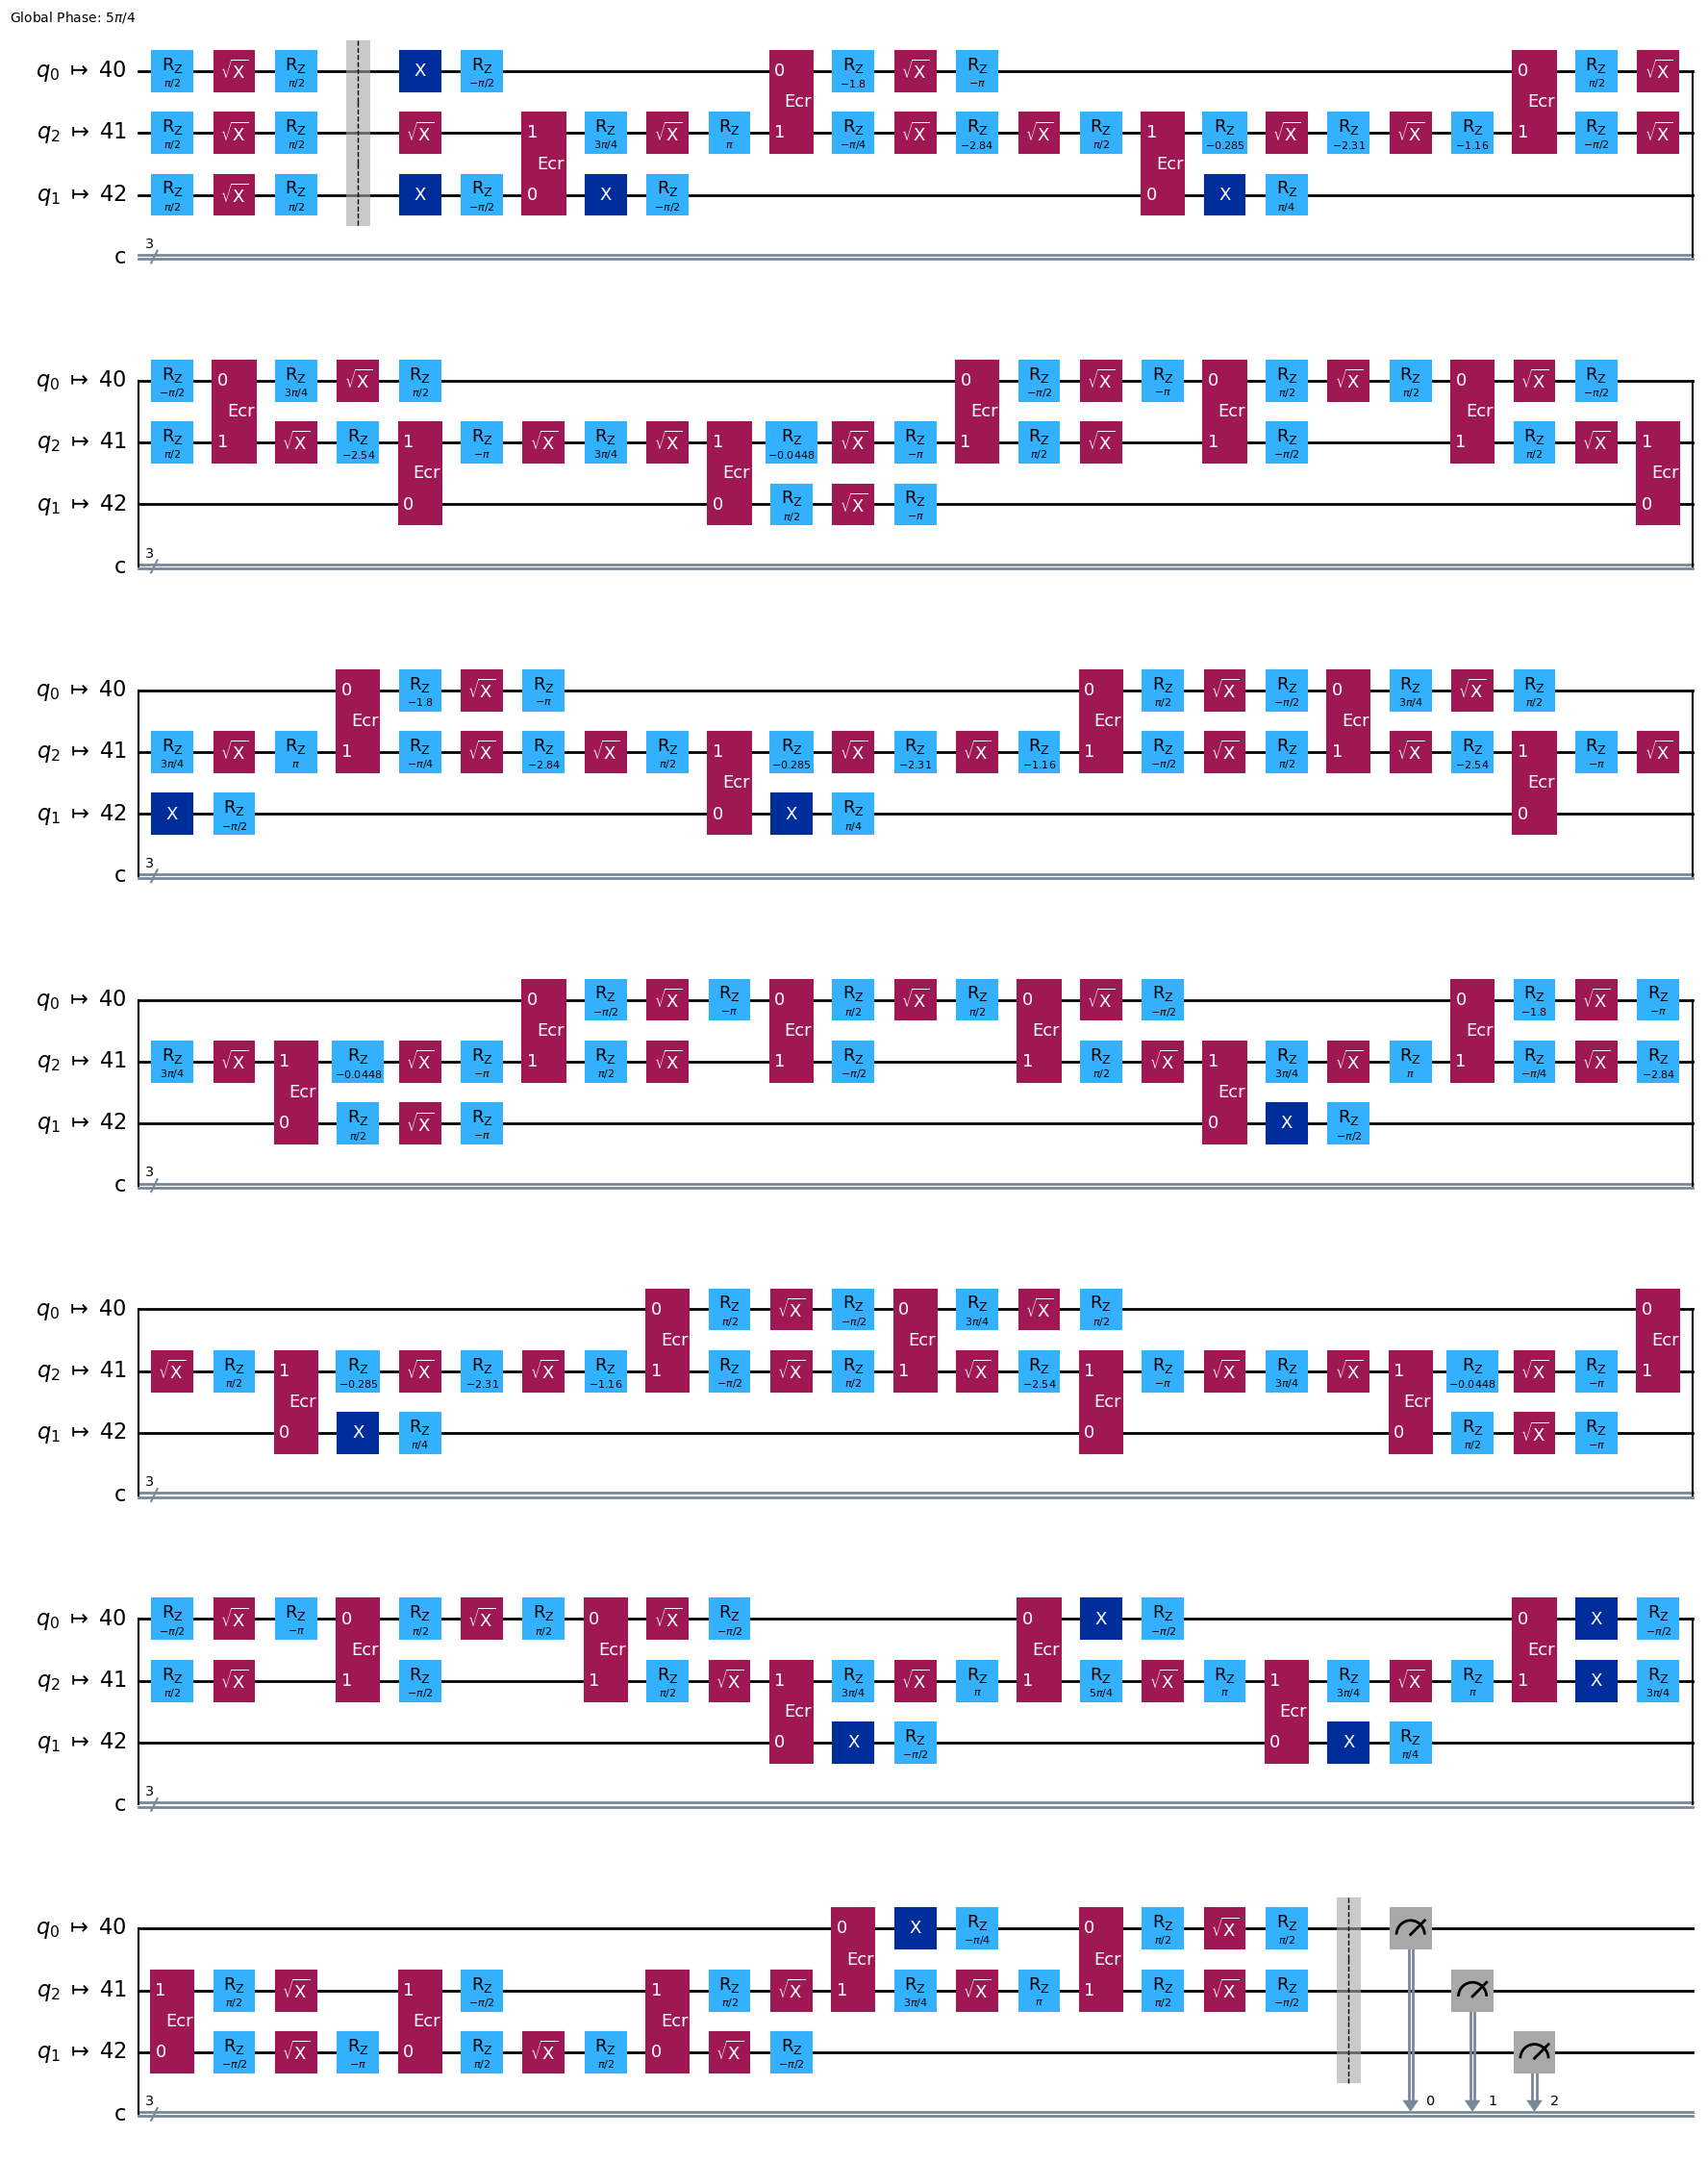

**Transpiled circuit |001⟩ on ibm_brisbane:**

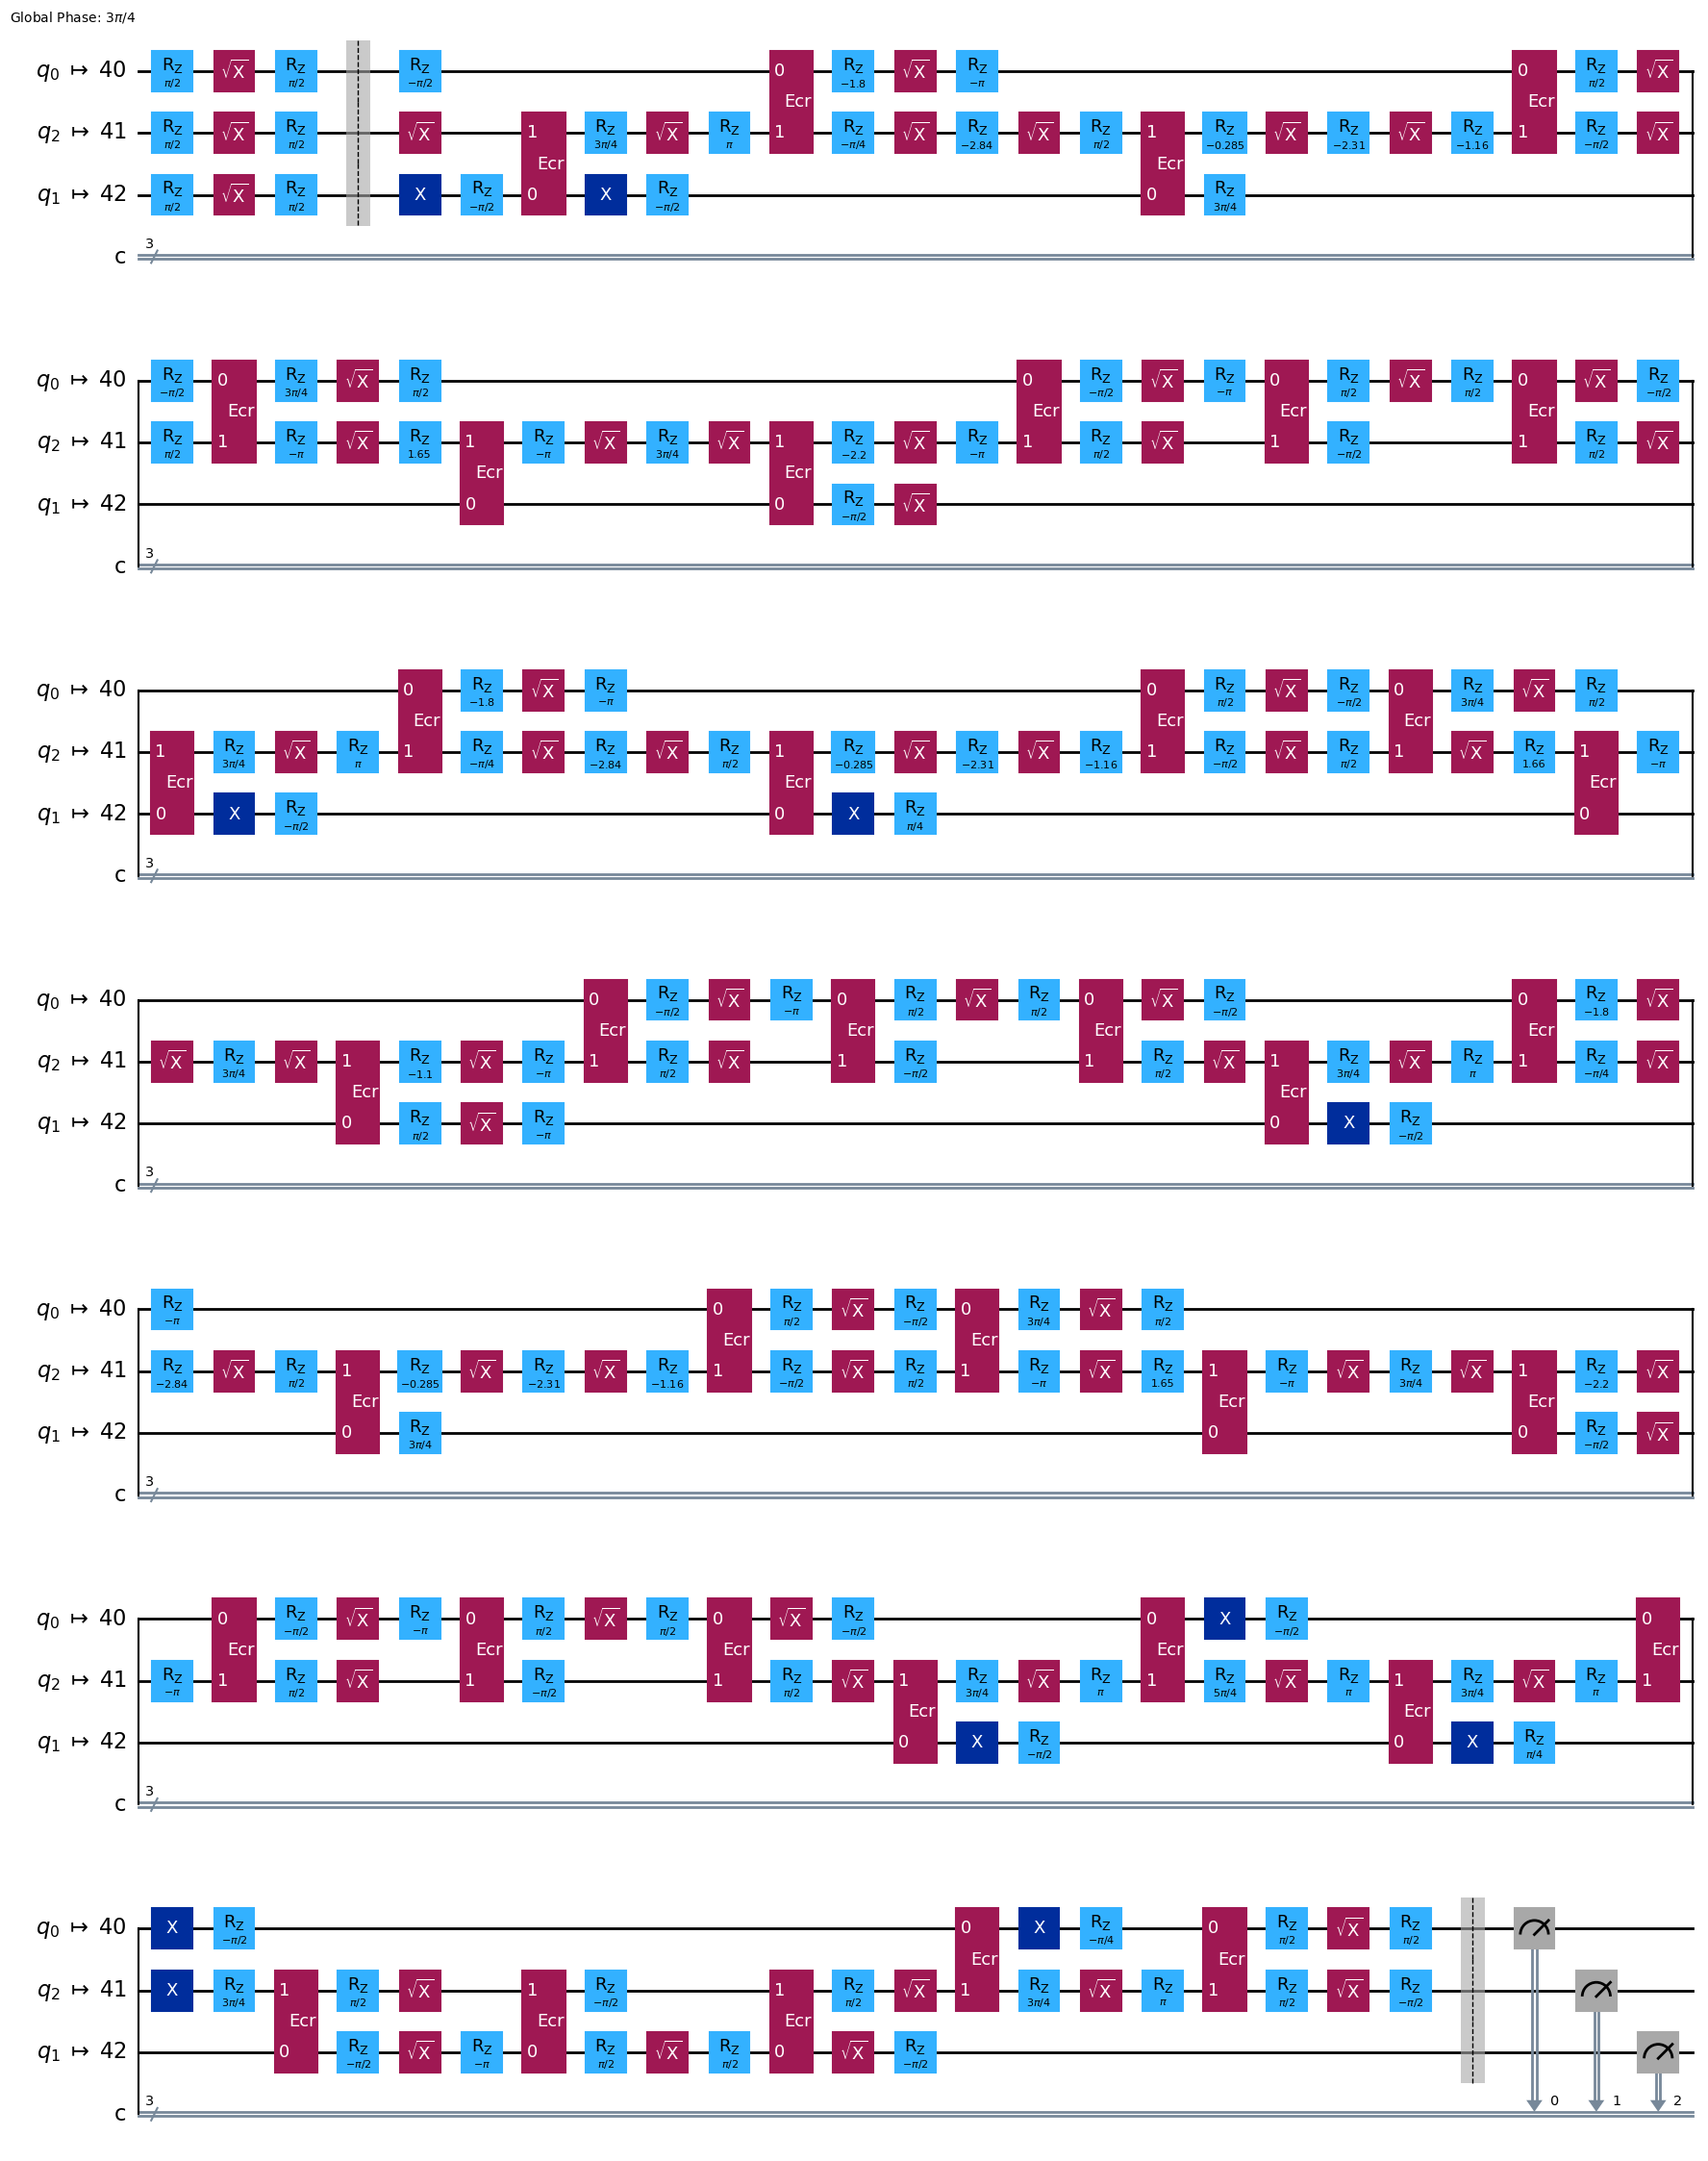

**Transpiled circuit |010⟩ on ibm_brisbane:**

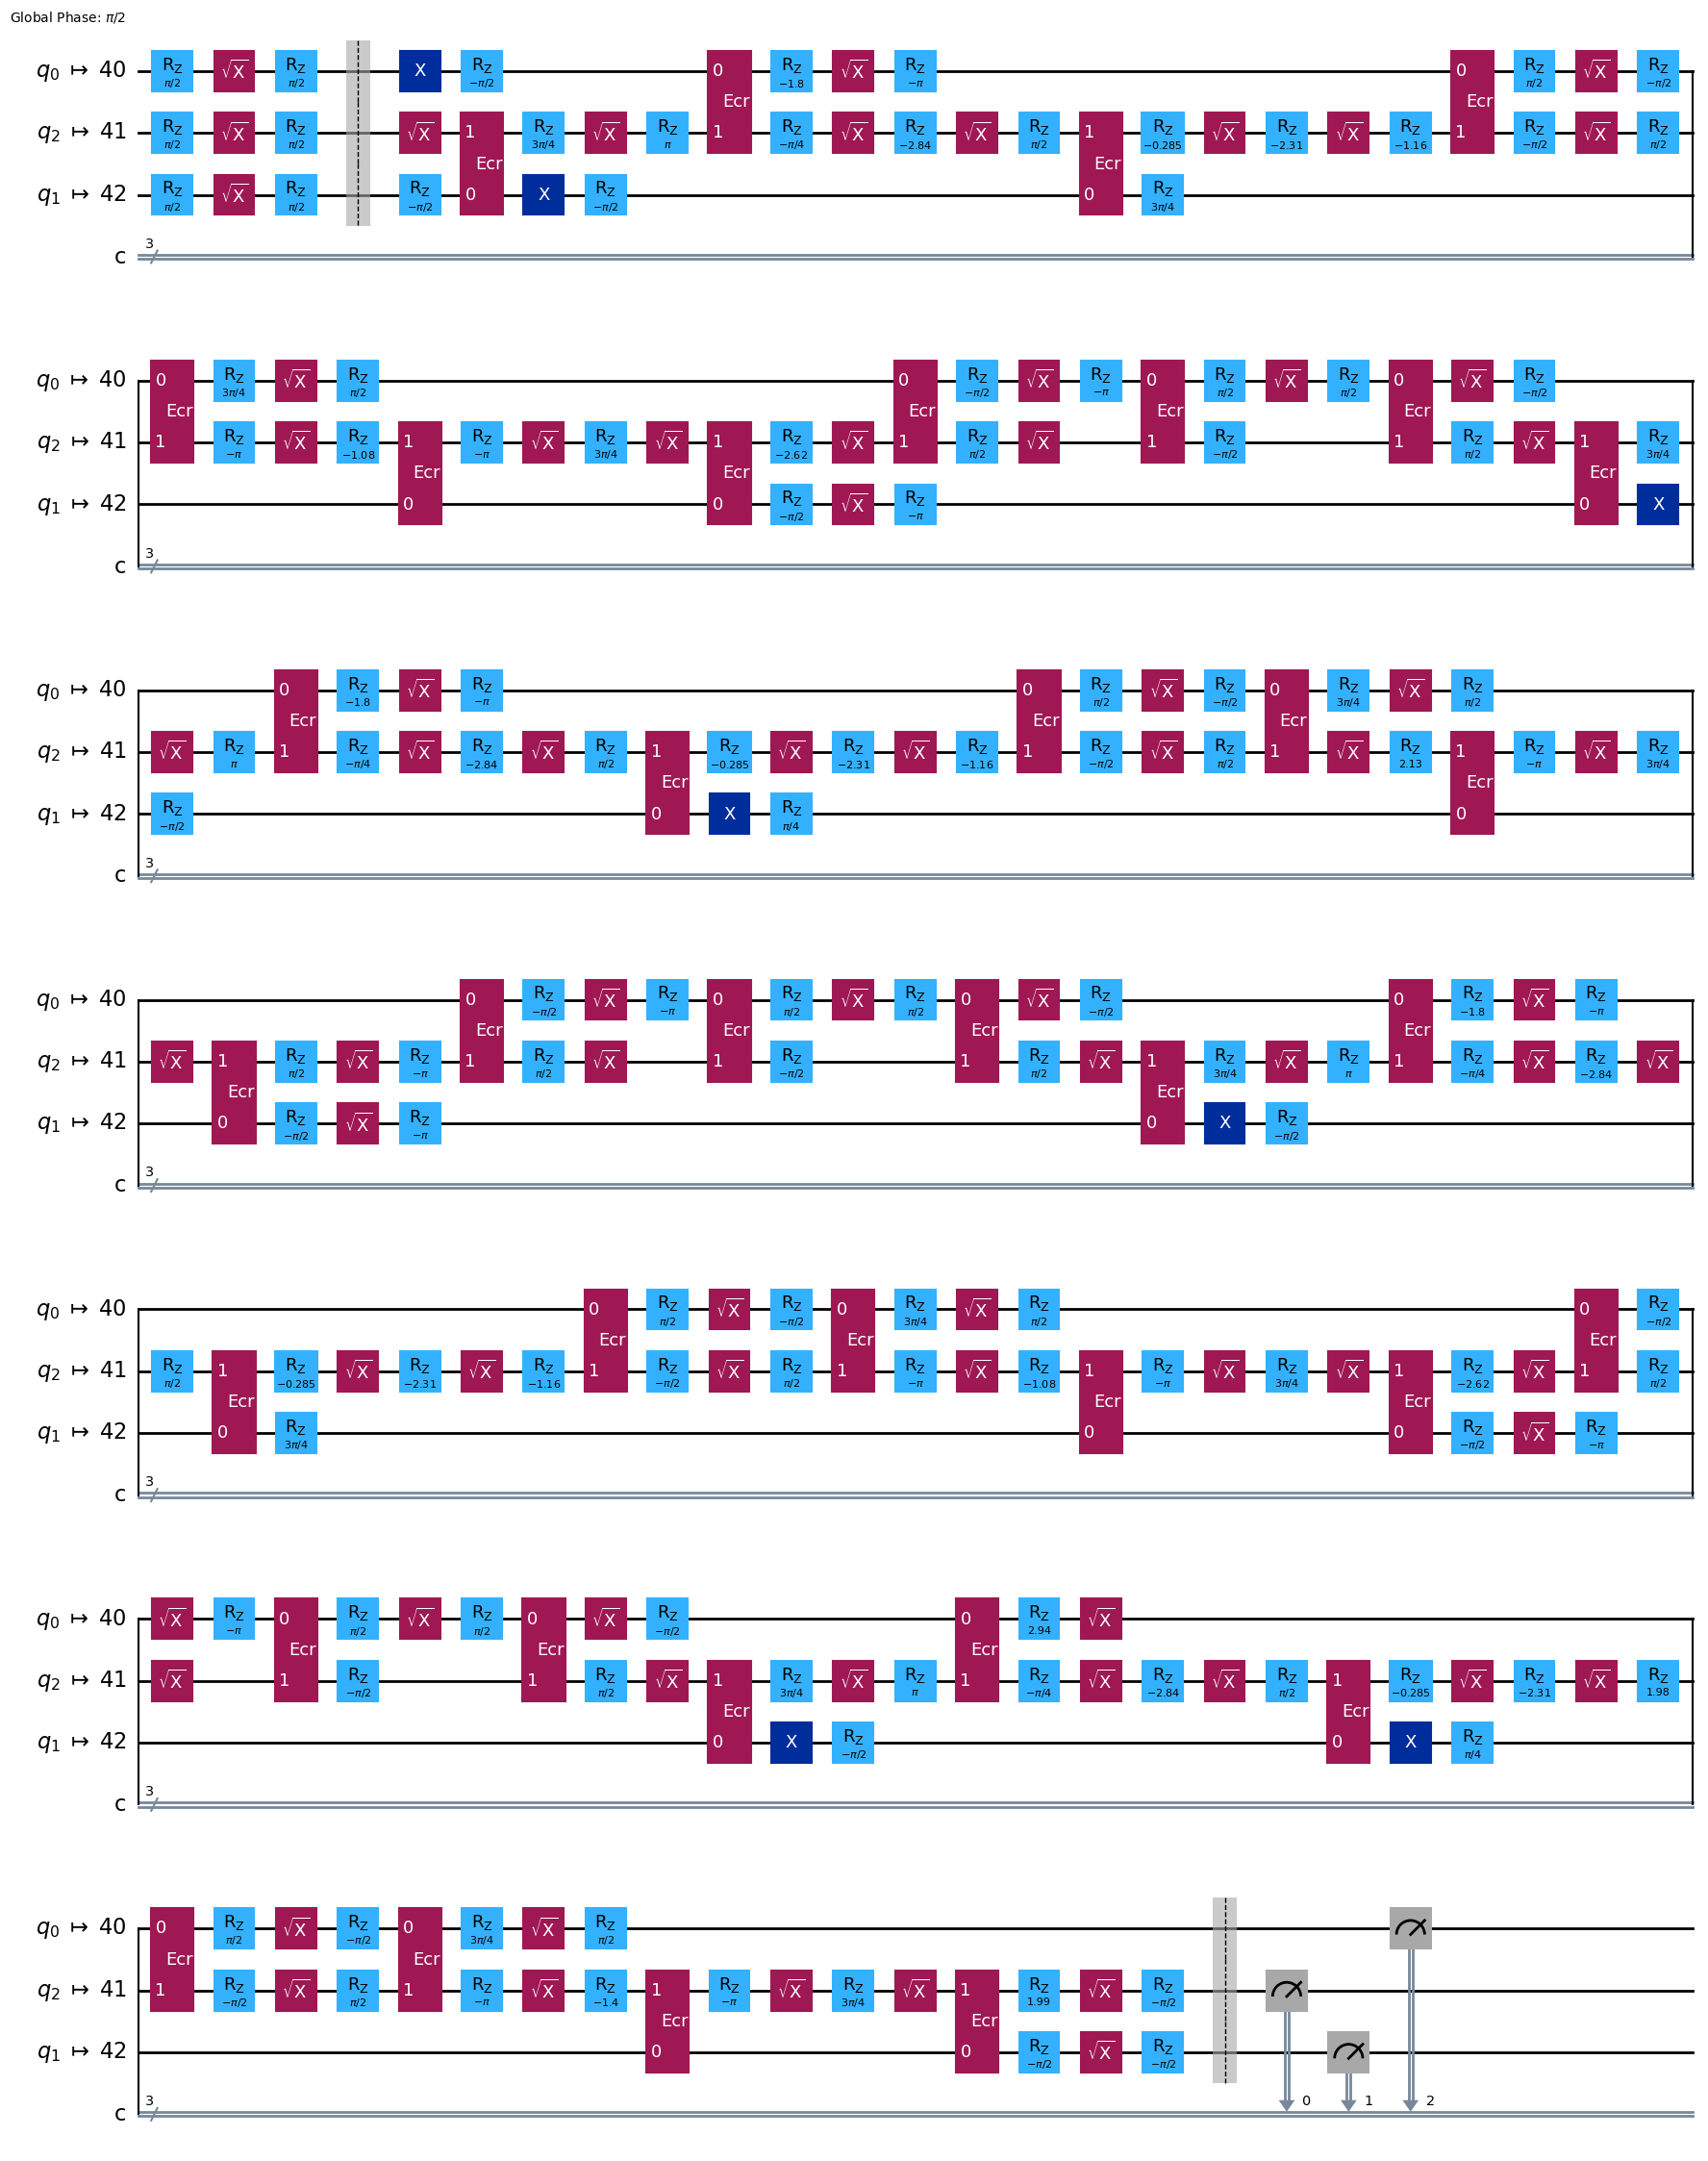

**Transpiled circuit |011⟩ on ibm_brisbane:**

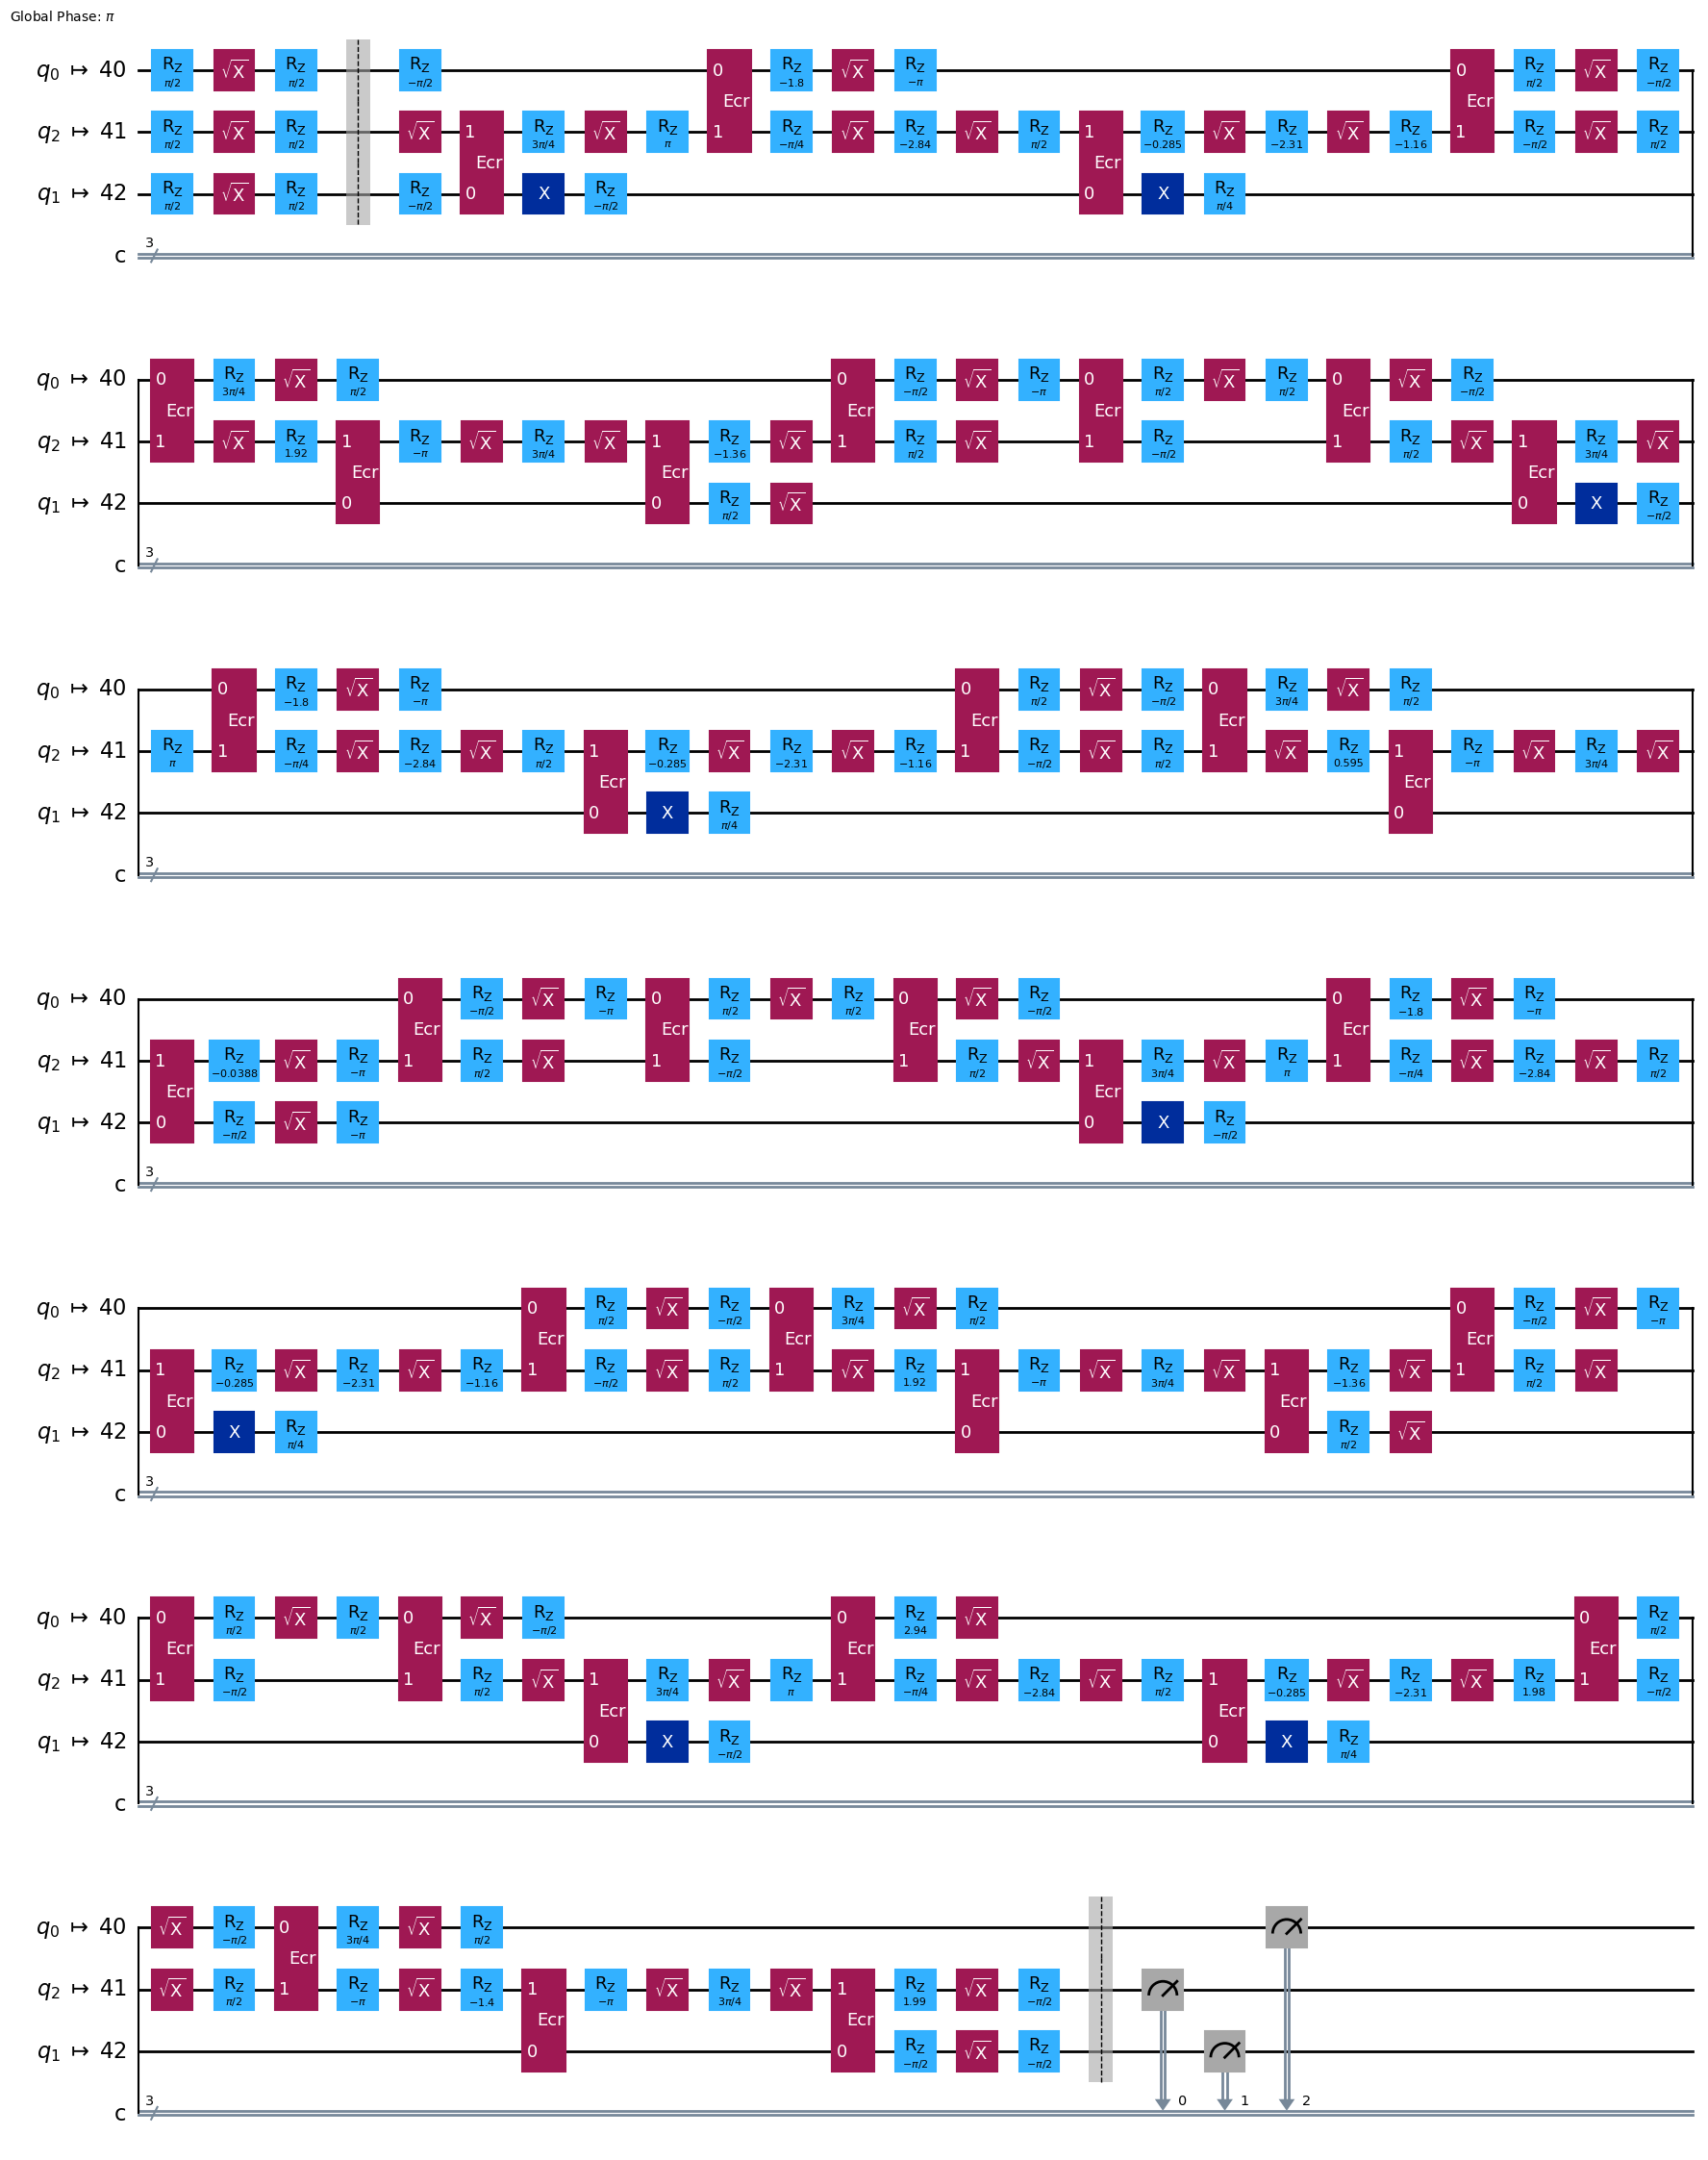

**Transpiled circuit |100⟩ on ibm_brisbane:**

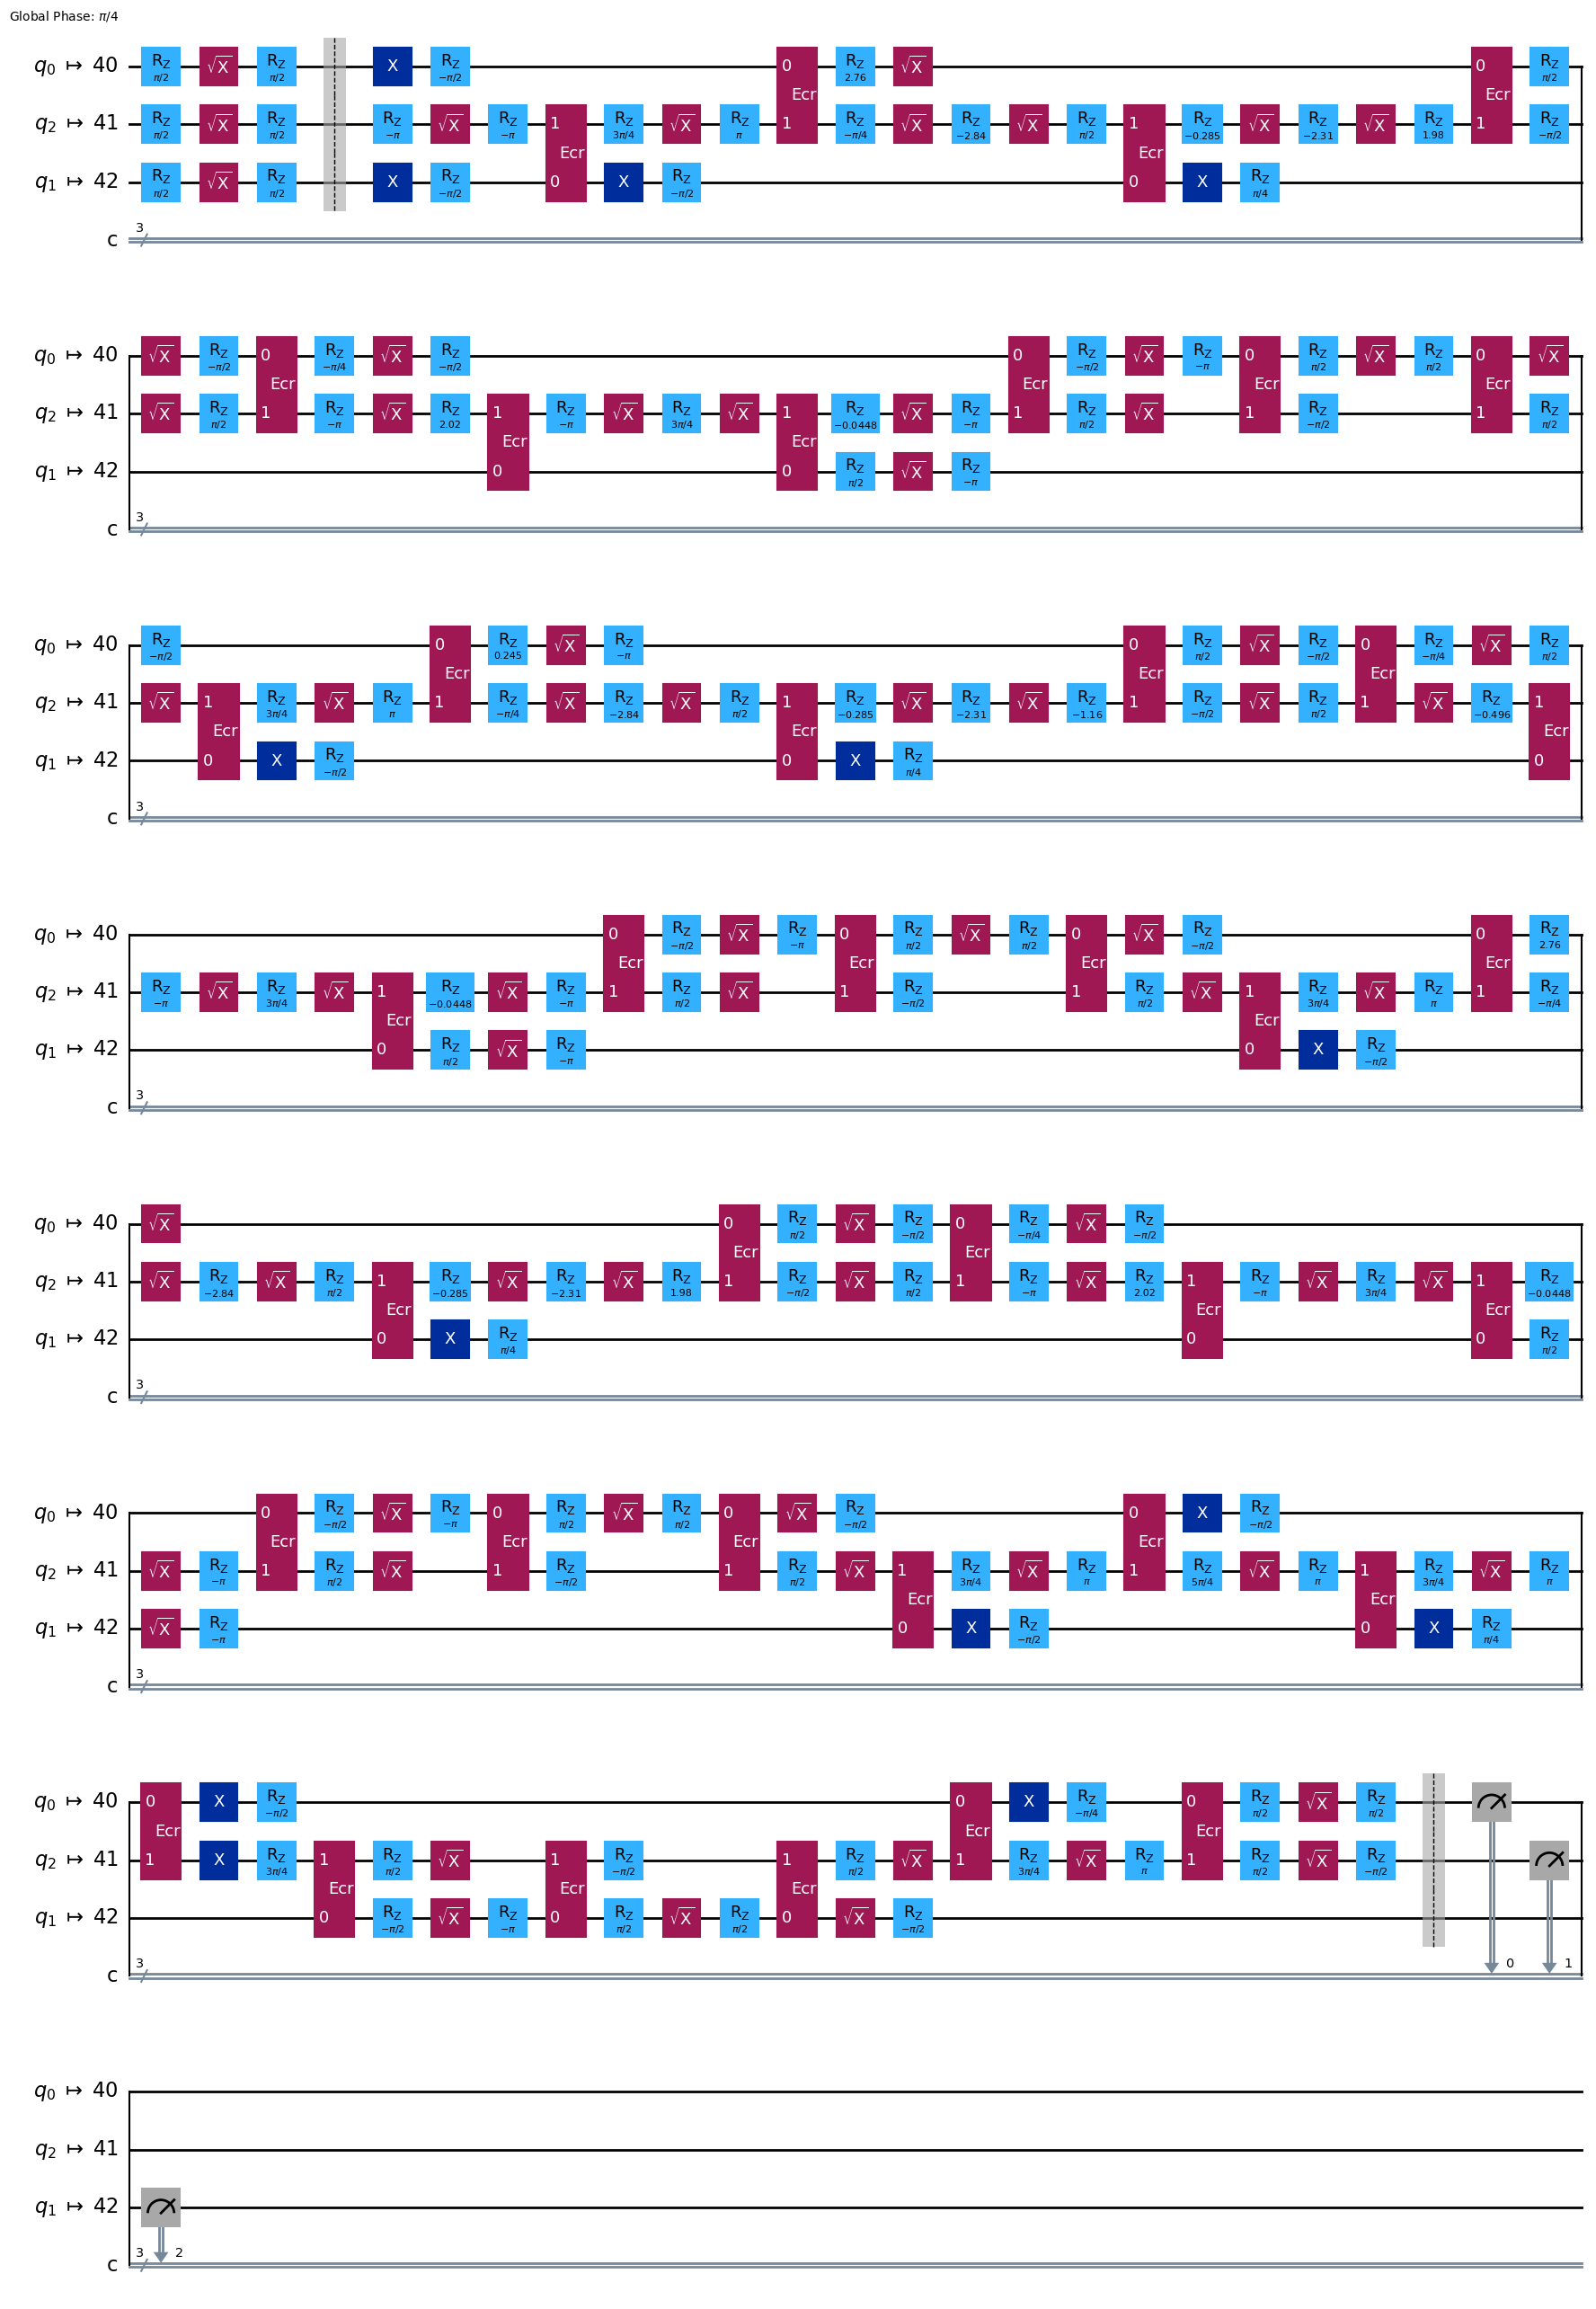

**Transpiled circuit |101⟩ on ibm_brisbane:**

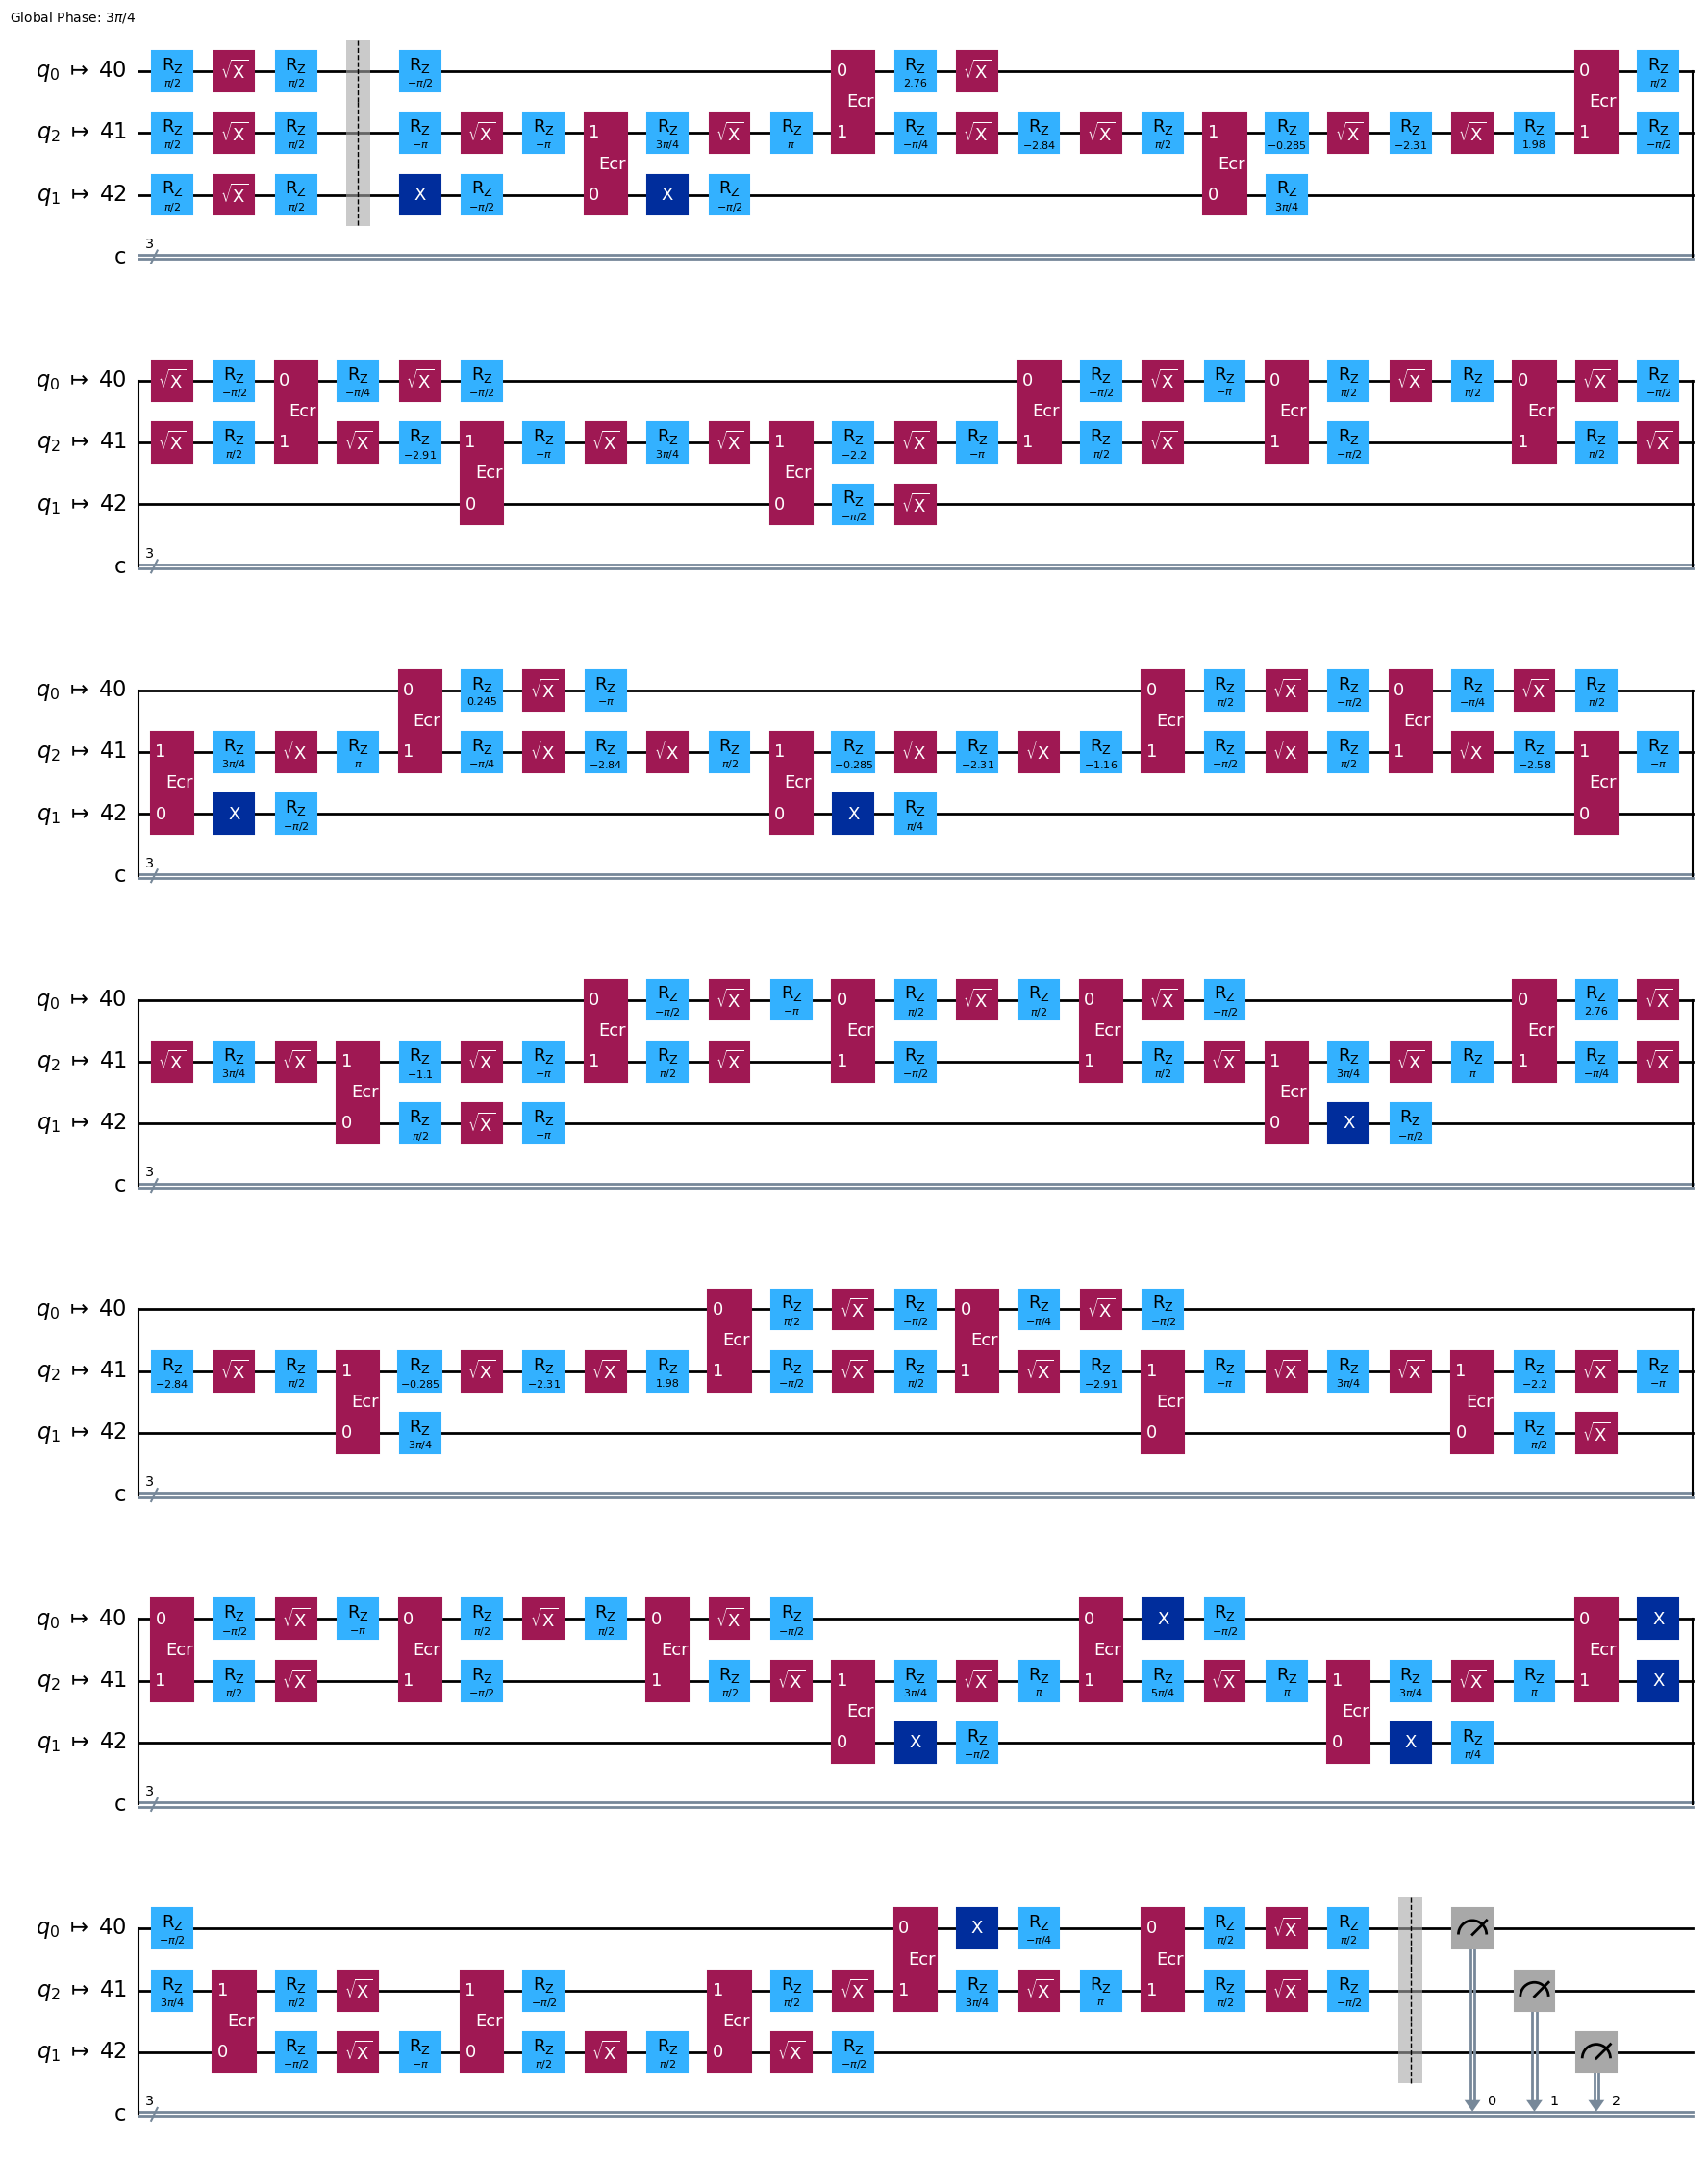

**Transpiled circuit |110⟩ on ibm_brisbane:**

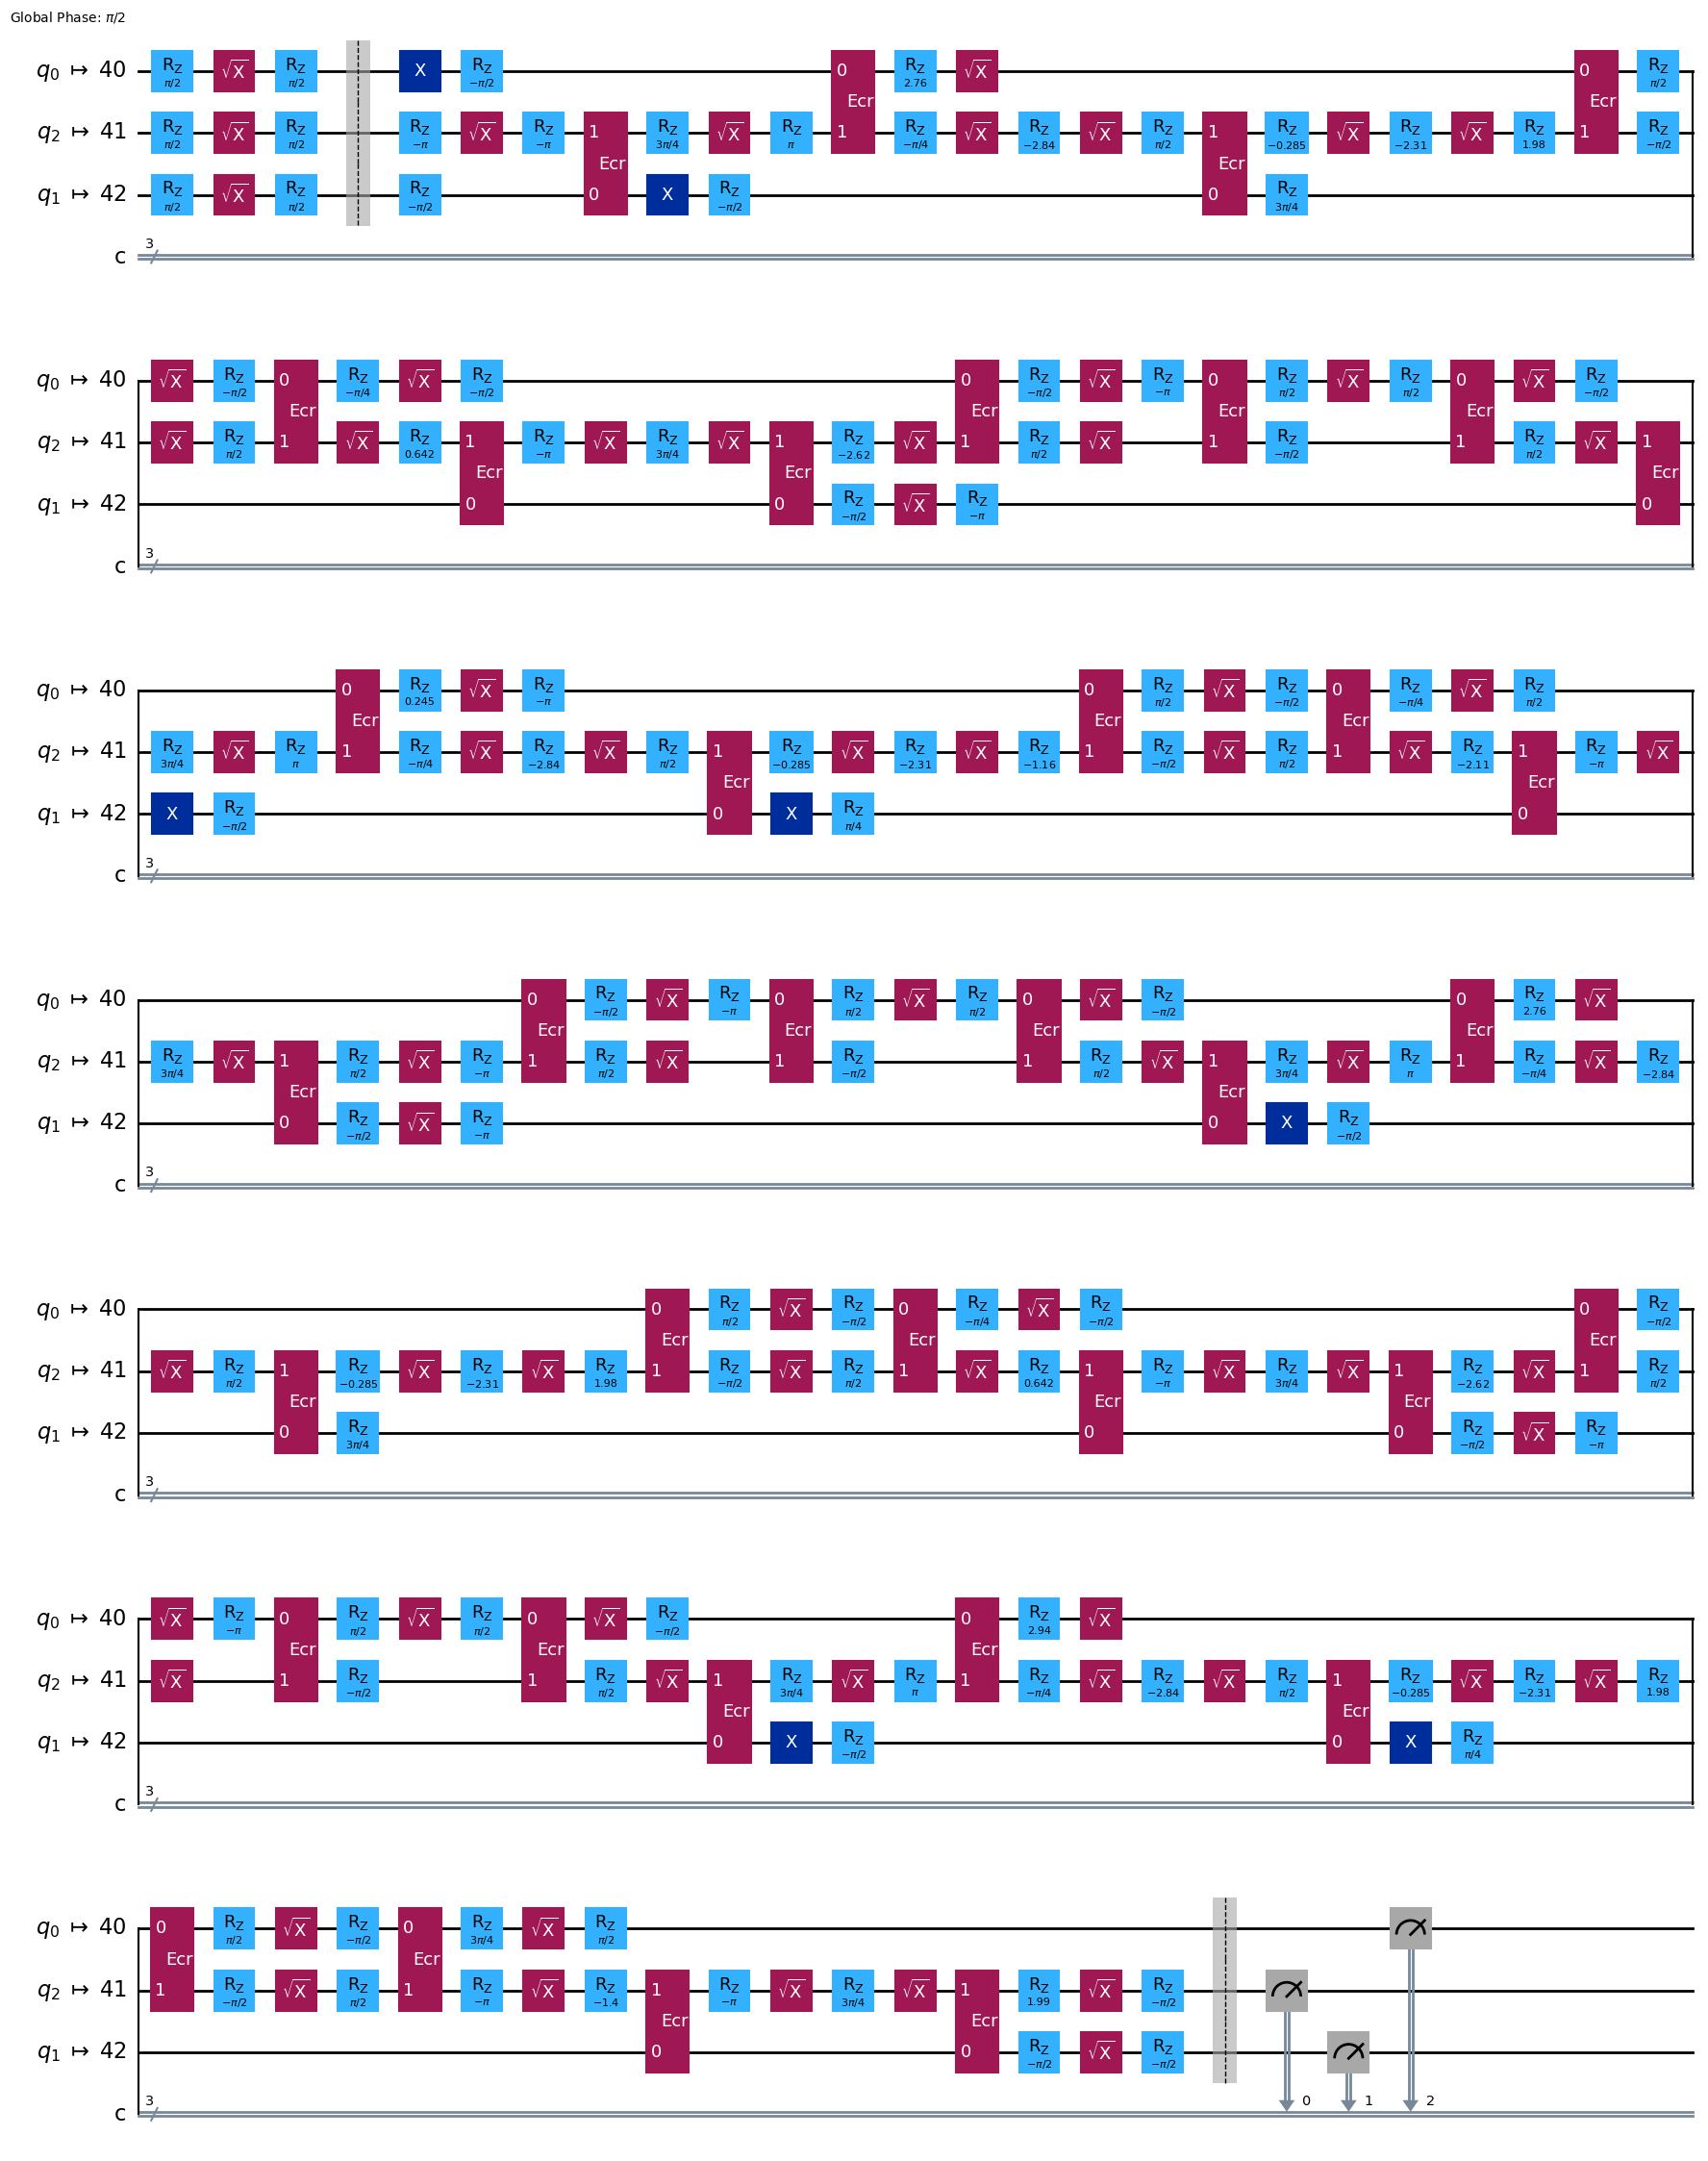

**Transpiled circuit |111⟩ on ibm_brisbane:**

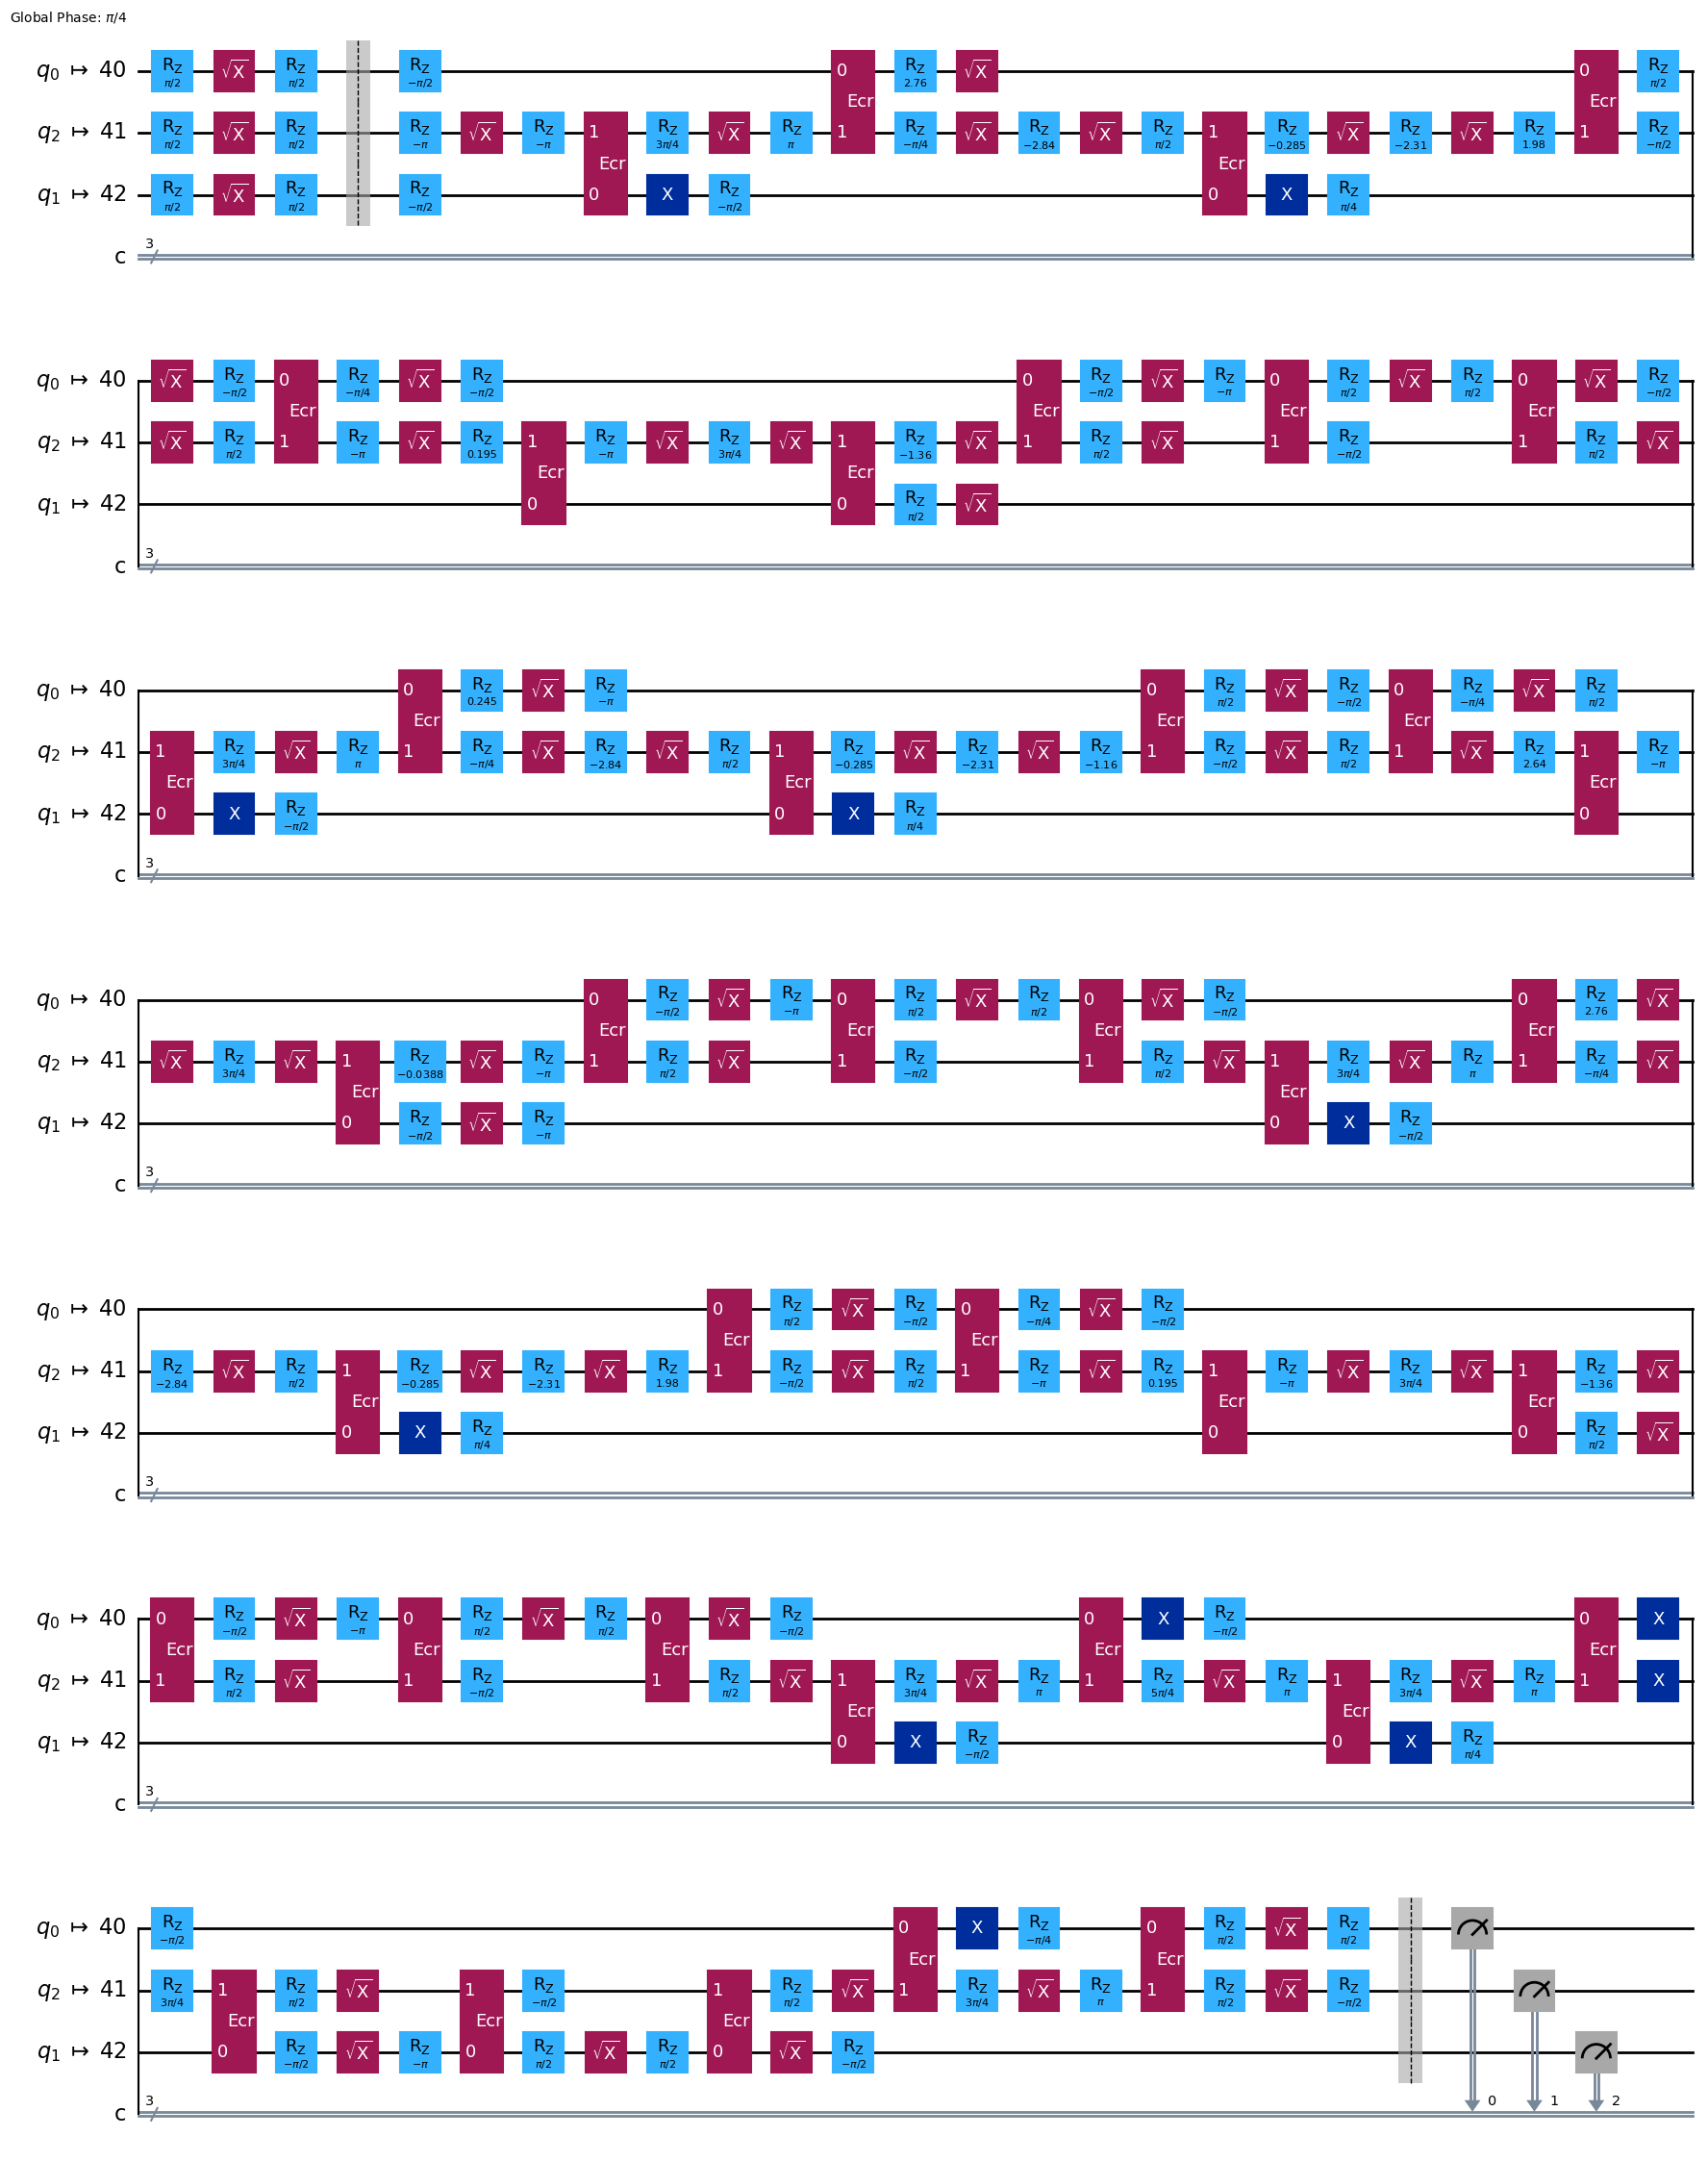

/var/folders/rc/j294rj094lb9j6zz6fcghj7m0000gn/T/ipykernel_3935/3718297879.py:174: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  sampler = Sampler(backend=backend)



Submitted 8 circuits; Job ID = d0ttn1wvx7bg0081dfvg


RuntimeJobFailureError: 'Unable to retrieve job result. Error code 1513; The VNone Primitives are not supported. Please use Primitives V2 -- Use a supported version of the primitive. See the `Qiskit Runtime release notes <https://quantum.cloud.ibm.com/docs/api/qiskit-ibm-runtime/release-notes>`__ to learn what is supported. -- https://ibm.biz/error_codes#1513'

In [ ]:
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import GroverOperator
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
from qiskit_algorithms import Grover, AmplificationProblem

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Markdown


# -----------------------------------------------------------------------------
# IBM Quantum authentication
# -----------------------------------------------------------------------------
try:
    QiskitRuntimeService.save_account(
        channel="ibm_quantum",
        token="7a7db01ab67f2e9082827e16b71b7ca5230d0c4137133a0c9c28a70c96a12bfc92df1005263db0b17d7885549ea8326c9f04f6f3fb409ff08c633ebff8b59561",
        overwrite=True
    )
    service = QiskitRuntimeService(channel="ibm_quantum")
    display(Markdown("## IBM Quantum Authentication Successful"))
except Exception as e:
    display(Markdown(f"## IBM Quantum Authentication Failed: {e}"))
    display(Markdown(
        "Please ensure your IBM Quantum token is correctly set. "
        "Hardware execution will be skipped."
    ))
    service = None


# -----------------------------------------------------------------------------
# Backend selection and status reporting
# -----------------------------------------------------------------------------
def select_backend(service, backend_name="ibm_brisbane"):
    """Select and report on an IBM Quantum backend."""
    try:
        backend = service.backend(name=backend_name)
        status = backend.status()
        config = backend.configuration()

        if not status.operational:
            raise RuntimeError(f"{backend_name} is not operational.")

        if config.simulator and backend_name != "ibmq_qasm_simulator":
            display(Markdown(f"Selected backend `{backend_name}` is a simulator."))

        display(Markdown(f"## Backend Selected: {backend.name}"))
        display(Markdown(f"* Status: {'Operational' if status.operational else 'Not Operational'}"))
        display(Markdown(f"* Qubit Count: {config.n_qubits}"))
        display(Markdown(f"* Pending Jobs: {status.pending_jobs}"))

        return backend

    except Exception as e:
        display(Markdown(f"## Could not get backend `{backend_name}`: {e}"))
        display(Markdown("Hardware execution will be skipped."))
        return None


backend = select_backend(service) if service else None


# -----------------------------------------------------------------------------
# Oracle construction
# -----------------------------------------------------------------------------
def construct_oracle(marked_state: str) -> QuantumCircuit:
    """
    Build a phase oracle that flips the sign of the |marked_state⟩ basis vector.
    """
    n = len(marked_state)
    oracle = QuantumCircuit(n)

    # Apply X gates to flip '0' bits to '1'
    for i, bit in enumerate(marked_state):
        if bit == '0':
            oracle.x(i)

    # Multi-controlled Z on |1...1⟩
    if n == 1:
        oracle.z(0)
    elif n == 2:
        oracle.cz(0, 1)
    else:
        oracle.h(n - 1)
        oracle.mcx(list(range(n - 1)), n - 1)
        oracle.h(n - 1)

    # Undo X gates
    for i, bit in enumerate(marked_state):
        if bit == '0':
            oracle.x(i)

    return oracle


# -----------------------------------------------------------------------------
# Grover circuits: generation, simulation, and (optionally) hardware run
# -----------------------------------------------------------------------------
n = 3
all_states = [format(i, f'0{n}b') for i in range(2**n)]

sim = AerSimulator()
logical_circuits = []
sim_results = {}
metrics = {}

# Build and simulate each Grover circuit
for raw_state in all_states:
    rev_state = raw_state[::-1]
    oracle = construct_oracle(rev_state)
    grover_op = GroverOperator(oracle)
    k = math.floor(math.pi / 4 * math.sqrt(2**n))

    qc = QuantumCircuit(n, n)
    qc.h(range(n))
    qc.barrier()
    for _ in range(k):
        qc.compose(grover_op, inplace=True)
    qc.barrier()
    qc.measure(range(n), range(n))

    # Record untranspiled metrics
    ops = qc.count_ops()
    metrics[raw_state] = {
        "gate_count_raw": sum(ops.values()),
        "cx_count_raw": ops.get('cx', 0),
        "depth_raw": qc.depth()
    }
    logical_circuits.append((raw_state, qc))

    # Display circuits
    display(Markdown(f"---\n### Circuit for |{raw_state}⟩"))
    display(qc.draw(output="mpl"))
    display(Markdown(f"#### Decomposed circuit for |{raw_state}⟩"))
    display(qc.decompose().draw(output="mpl", idle_wires=False))

    # Local simulation
    qc_sim = transpile(qc, sim)
    job = sim.run(qc_sim, shots=1024).result()
    counts = job.get_counts()
    sim_results[raw_state] = counts

    display(Markdown(f"**Simulator results for |{raw_state}⟩:** `{counts}`"))
    display(plot_histogram(counts, title=f"Simulator |{raw_state}⟩"))

# Transpile for hardware (if available) and run
if service and backend:
    pm = generate_preset_pass_manager(
        target=backend.target,
        optimization_level=3
    )
    hw_circuits = []

    for state, qc in logical_circuits:
        qc_isa = pm.run(qc)
        hw_circuits.append(qc_isa)
        ops_isa = qc_isa.count_ops()

        # Update metrics with ISA‐mapped data
        metrics[state].update({
            "gate_count_isa": sum(ops_isa.values()),
            "cx_count_isa": ops_isa.get('cx', 0),
            "depth_isa": qc_isa.depth()
        })

        display(Markdown(f"**Transpiled circuit |{state}⟩ on {backend.name}:**"))
        display(qc_isa.draw(output="mpl", idle_wires=False))

    sampler = Sampler(backend=backend)
    job = sampler.run(hw_circuits, shots=1024)
    print(f"\nSubmitted {len(hw_circuits)} circuits; Job ID = {job.job_id()}")

    for (state, _), result in zip(logical_circuits, job.result()):
        counts = result.join_data().get_counts()
        display(plot_histogram(counts, title=f"{backend.name} |{state}⟩"))

# -----------------------------------------------------------------------------
# Compile and show metrics table
# -----------------------------------------------------------------------------
df_metrics = pd.DataFrame.from_dict(metrics, orient='index')
df_metrics.index.name = 'raw_state'
df_metrics = df_metrics.reset_index()
display(df_metrics)

# Plot gate-count comparison
plt.figure(figsize=(6, 4))
plt.bar(df_metrics['raw_state'], df_metrics['gate_count_raw'], label='raw')
plt.bar(df_metrics['raw_state'], df_metrics['gate_count_isa'], label='isa', alpha=0.7)
plt.ylabel('Total Gate Count')
plt.title('Gate Count: Raw vs. ISA-mapped')
plt.legend()
plt.show()




In [ ]:
# -----------------------------------------------------------------------------
# Baseline: Qiskit-built Grover API at optimization_level=3
# -----------------------------------------------------------------------------
baseline_metrics = {}
baseline_sim = {}
baseline_hw = {}

for raw_state in all_states:
    rev_state = raw_state[::-1]
    oracle = construct_oracle(rev_state)

    problem = AmplificationProblem(
        oracle=oracle,
        is_good_state=lambda bitstr: bitstr == rev_state,
        post_processing=None
    )
    k = math.floor(math.pi / 4 * math.sqrt(2**n))
    grover_algo = Grover(iterations=k)

    qc_bl = grover_algo.construct_circuit(problem)
    qc_bl.measure_all()

    # Baseline metrics
    ops_bl = qc_bl.count_ops()
    baseline_metrics[raw_state] = {
        "gate_bl_raw": sum(ops_bl.values()),
        "cx_bl_raw": ops_bl.get('cx', 0),
        "depth_bl_raw": qc_bl.depth()
    }

    # Simulation
    qc_bl_sim = transpile(qc_bl, sim)
    counts_bl = sim.run(qc_bl_sim, shots=1024).result().get_counts()
    baseline_sim[raw_state] = counts_bl

    # ISA-mapped for backend
    qc_bl_isa = transpile(qc_bl, backend, optimization_level=3) if backend else None
    if qc_bl_isa:
        ops_bl_isa = qc_bl_isa.count_ops()
        baseline_metrics[raw_state].update({
            "gate_bl_isa": sum(ops_bl_isa.values()),
            "cx_bl_isa": ops_bl_isa.get('cx', 0),
            "depth_bl_isa": qc_bl_isa.depth()
        })

    # Display baseline circuits and histograms
    display(Markdown(f"### Qiskit-Grover baseline for |{raw_state}⟩"))
    display(qc_bl.draw(output="mpl"))
    if qc_bl_isa:
        display(Markdown("#### Opt3 ISA-mapped"))
        display(qc_bl_isa.draw(output="mpl", idle_wires=False))

    display(Markdown(f"**Simulator counts (baseline) |{raw_state}⟩:** `{counts_bl}`"))
    display(plot_histogram(counts_bl, title=f"Baseline Simulator |{raw_state}⟩"))

    if backend and qc_bl_isa:
        bl_job = Sampler(backend=backend).run([qc_bl_isa], shots=1024)
        bl_counts_hw = bl_job.result().join_data().get_counts()
        baseline_hw[raw_state] = bl_counts_hw
        display(Markdown(f"**Hardware counts (baseline) |{raw_state}⟩:** `{bl_counts_hw}`"))
        display(plot_histogram(bl_counts_hw, title=f"Baseline Hardware |{raw_state}⟩"))

# Final baseline DataFrame
df_baseline = (
    pd.DataFrame.from_dict(baseline_metrics, orient='index')
      .reset_index()
      .rename(columns={'index': 'raw_state'})
)
df_baseline['sim_counts'] = df_baseline['raw_state'].map(baseline_sim)
df_baseline['hw_counts'] = df_baseline['raw_state'].map(baseline_hw)
display(df_baseline)